# ICU Mortality Prediction Using Nursing Care Frequency
## Severity-Stratified XGBoost Analysis — Mouthcare and Turning
### MIMIC-IV Dataset

| Parameter | Specification |
|---|---|
| **Outcome variable** | `hospital_expire_flag` (in-hospital mortality) |
| **Predictive features** | LODS proxies (SOFA subscores) + APS III proxies (laboratory values, vital signs, GCS) |
| **Care frequency variable** | `average_item_interval` — mean hours between care events per patient |
| **Q1 definition** | Smallest `average_item_interval` = highest care frequency |
| **Q4 definition** | Largest `average_item_interval` = lowest care frequency |
| **Severity stratification** | Total SOFA score: Low (0–6), Medium (7–11), High (≥12), aligned with Sepsis-3 criteria |
| **Quartile assignment** | Within each severity stratum independently |
| **Model A** | Trained on 70% of all quartiles within severity stratum; tested on 30% of each quartile |
| **Model B** | Trained on 70% of Q1 only; tested on held-out 30% of Q1 and 100% of Q2, Q3, Q4 |
| **Confidence intervals** | Bootstrap resampling, 1000 iterations, 95% CI |

---

**Study hypothesis:** A model trained exclusively on patients receiving the highest frequency of nursing care (Q1) will demonstrate declining discriminative performance when applied to patients with progressively lower care frequency (Q2–Q4), after controlling for illness severity. This decline would indicate that care frequency independently contributes to mortality risk beyond what clinical severity scores alone can explain.

**Rationale for within-severity quartile assignment:** Without severity stratification, critically ill patients naturally receive more intensive nursing care — a phenomenon known as reverse causation. Assigning quartiles within severity strata ensures that Q1 and Q4 patients share comparable illness burden, so observed differences in model performance reflect care frequency rather than underlying acuity.

---

## 1. Package Installation and Import

In [1]:
import subprocess, sys
for pkg in ['xgboost','scikit-learn','pandas','numpy','openpyxl','matplotlib','seaborn','shap']:
    try:
        __import__(pkg.replace('-','_'))
    except ImportError:
        print(f'Installing {pkg}...')
        subprocess.check_call([sys.executable,'-m','pip','install',pkg,'-q'])

import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix,
    precision_score, recall_score, f1_score
)

from sklearn.calibration import calibration_curve
import xgboost as xgb
from openpyxl import Workbook
from openpyxl.styles import PatternFill, Font, Alignment, Border, Side
from openpyxl.utils import get_column_letter

warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams.update({
    'font.family':'DejaVu Sans','font.size':11,
    'axes.spines.top':False,'axes.spines.right':False,
    'axes.grid':True,'grid.alpha':0.3,'figure.dpi':130
})
print(' All packages ready!')

Installing scikit-learn...
 All packages ready!


/Users/rf597/miniforge3/envs/ml4h/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. File Path Configuration

Modify the two directory paths below to point to the local mouthcare and turning data folders. All other configuration is handled automatically.

In [8]:
MOUTHCARE_FOLDER = r"./mouthcare"
TURNING_FOLDER   = r"./turningcare"
OUTPUT_FOLDER = r"figures"
OUTPUT_EXCEL  = r"mortality_results.xlsx"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

print(f'Mouthcare : {"" if os.path.exists(MOUTHCARE_FOLDER) else " NOT FOUND"}  {MOUTHCARE_FOLDER}')
print(f'Turning   : {"" if os.path.exists(TURNING_FOLDER)   else " NOT FOUND"}  {TURNING_FOLDER}')

Mouthcare :   ./mouthcare
Turning   :   ./turningcare


## 3. Analysis Constants and Feature Definitions

In [9]:
PATIENT_ID   = 'stay_id'
MORTALITY    = 'hospital_expire_flag'
FREQ_COL     = 'average_item_interval'  # smaller = more frequent care
SOFA_COL     = 'SOFA'
N_BOOTSTRAP  = 1000
QUARTILES    = ['Q1','Q2','Q3','Q4']

# 
# Severity groups based on SOFA score
# Rationale: SOFA is the internationally validated ICU organ dysfunction
# score used in Sepsis-3 definitions (Singer et al., JAMA 2016).
# Cut-points 0-6 / 7-11 / 12+ are widely used in high-impact ICU literature
# and map cleanly to mild / moderate / severe organ dysfunction.
# 
SEVERITY_LABELS = ['Low','Medium','High']
SEVERITY_CUTS   = [-1, 6, 11, 999]   # SOFA: Low 0-6, Medium 7-11, High 12+

LODS_COLS = ['respiration','cardiovascular','liver','coagulation','renal','cns']
APSIII_COLS = [
    'heart_rate_min','heart_rate_max','heart_rate_mean',
    'mbp_min','mbp_max','mbp_mean',
    'temperature_min','temperature_max','temperature_mean',
    'resp_rate_min','resp_rate_max','resp_rate_mean',
    'hematocrit_min','hematocrit_max',
    'wbc_min','wbc_max',
    'creatinine_min','creatinine_max',
    'bun_min','bun_max',
    'sodium_min','sodium_max',
    'albumin_min','albumin_max',
    'bilirubin_total_min','bilirubin_total_max',
    'glucose_min','glucose_max',
    'bicarbonate_min','bicarbonate_max',
    'gcs_min',
]
FEATURE_COLS = LODS_COLS + APSIII_COLS

# Colours
SEV_COLOURS = {'Low':'#2E86C1','Medium':'#E67E22','High':'#C0392B'}
Q_COLOURS   = {'Q1':'#1A5276','Q2':'#2471A3','Q3':'#E67E22','Q4':'#C0392B'}
MODEL_STYLES = {
    'A – All Quartiles': {'color':'#2874A6','marker':'o','ls':'-',  'label':'Model A (all Q)'},
    'B – Q1 Only':       {'color':'#1E8449','marker':'s','ls':'--', 'label':'Model B (Q1 trained)'},
}
print(' Constants set!')

 Constants set!


## 4. Data Loading and Preprocessing

In [10]:
def load_folder(folder):
    file_map = {
        'cohort':        os.path.join(folder,'cohort.pkl'),
        'sofa':          os.path.join(folder,'sofa.pkl'),
        'vitals':        os.path.join(folder,'vitals.pkl'),
        'lab':           os.path.join(folder,'lab.pkl'),
        'gcs':           os.path.join(folder,'gcs.pkl'),
        'proxy':         os.path.join(folder,'proxy.pkl'),
        'comorbidities': os.path.join(folder,'comorbidities.pkl'),
    }
    dfs = {}
    for name, path in file_map.items():
        if os.path.exists(path):
            dfs[name] = pd.read_pickle(path)
            print(f'   {name:15s} {dfs[name].shape}')
        else:
            print(f'    {name}.pkl not found')

    proxy_agg = dfs['proxy'].groupby(PATIENT_ID).agg(
        average_item_interval=('average_item_interval','mean'),
        item_volume          =('item_volume','sum'),
        n_caregivers         =('n_caregivers','mean'),
        icu_days             =('day','count'),
    ).reset_index()

    merged = dfs['cohort'][[PATIENT_ID, MORTALITY, 'admission_age', 'los_icu']].copy()
    for name in ['sofa','vitals','lab','gcs','comorbidities']:
        if name in dfs:
            df = dfs[name].drop(columns=['subject_id','hadm_id'], errors='ignore')
            merged = merged.merge(df, on=PATIENT_ID, how='left')
    merged = merged.merge(proxy_agg, on=PATIENT_ID, how='left')
    print(f'  → {len(merged):,} patients total | mortality: {merged[MORTALITY].mean()*100:.1f}%')
    return merged

print('Loading MOUTHCARE...')
mc_df = load_folder(MOUTHCARE_FOLDER)
print('\nLoading TURNING...')
turn_df = load_folder(TURNING_FOLDER)
print('\n Done!')

Loading MOUTHCARE...
   cohort          (26443, 13)
   sofa            (26443, 10)
   vitals          (26443, 26)
   lab             (26443, 88)
   gcs             (26443, 7)
   proxy           (37057, 5)
   comorbidities   (26443, 22)
  → 26,443 patients total | mortality: 18.2%

Loading TURNING...
   cohort          (26494, 13)
   sofa            (26494, 10)
   vitals          (26494, 26)
   lab             (26494, 88)
   gcs             (26494, 7)
   proxy           (40006, 5)
   comorbidities   (26494, 22)
  → 26,494 patients total | mortality: 18.3%

 Done!


## 5. Severity Stratification and Quartile Assignment

Quartiles are assigned within each severity stratum separately. This design ensures that comparisons between Q1 and Q4 reflect differences in care frequency among patients of equivalent clinical severity, controlling for the confounding effect of illness acuity on care intensity.

In [11]:
def assign_groups(df, care_label):
    """
    1. Assign severity group from SOFA score (Low/Medium/High)
    2. Within each severity group, assign Q1-Q4 by average_item_interval
       Q1 = smallest interval = most frequent care
       Q4 = largest interval  = least frequent care
    3. Keep only relevant columns and drop missing
    """
    avail = [c for c in FEATURE_COLS if c in df.columns]
    keep  = [PATIENT_ID, MORTALITY, FREQ_COL, SOFA_COL] + avail
    out   = df[[c for c in keep if c in df.columns]].copy()

    # Drop rows missing mortality or frequency
    out = out.dropna(subset=[MORTALITY, FREQ_COL]).copy()
    out[MORTALITY] = out[MORTALITY].astype(int)
    for col in avail + [FREQ_COL]:
        out[col] = pd.to_numeric(out[col], errors='coerce')
    out[SOFA_COL] = pd.to_numeric(out[SOFA_COL], errors='coerce')

    #  Step 1: Severity group from SOFA 
    out['severity'] = pd.cut(
        out[SOFA_COL],
        bins=SEVERITY_CUTS,
        labels=SEVERITY_LABELS,
        right=True
    ).astype(str)
    out.loc[out[SOFA_COL].isna(), 'severity'] = 'Unknown'

    #  Step 2: Quartiles WITHIN each severity group 
    # Q1 = smallest average_item_interval = most frequent care
    out['quartile'] = out.groupby('severity', group_keys=False)[FREQ_COL].transform(
        lambda x: pd.qcut(x, q=4, labels=QUARTILES, duplicates='drop')
    )

    # Drop patients whose quartile couldn't be assigned (rare edge case)
    n_before = len(out)
    out = out.dropna(subset=['quartile']).copy()
    out = out[out['severity'] != 'Unknown'].copy()
    n_dropped = n_before - len(out)
    if n_dropped > 0:
        print(f'    Dropped {n_dropped} patients (missing SOFA or unassignable quartile)')

    #  Step 3: Verification printout 
    print(f'\n{""*60}')
    print(f'  {care_label} — group verification')
    print(f'  Total patients: {len(out):,} | Mortality: {out[MORTALITY].mean()*100:.1f}%')
    print(f'\n  Mean SOFA by severity (should differ clearly):')
    print(' ', out.groupby('severity')[SOFA_COL].mean().round(2).reindex(SEVERITY_LABELS).to_dict())
    print(f'\n  Mean SOFA by quartile within severity (should be SIMILAR — proves balance):')
    sofa_check = out.groupby(['severity','quartile'], observed=True)[SOFA_COL].mean().round(2).unstack()
    print(sofa_check.reindex(SEVERITY_LABELS).to_string())
    print(f'\n  Mean interval by quartile within severity (Q1 should be smallest):')
    interval_check = out.groupby(['severity','quartile'], observed=True)[FREQ_COL].mean().round(3).unstack()
    print(interval_check.reindex(SEVERITY_LABELS).to_string())
    print(f'\n  Mortality by quartile within severity:')
    mort_check = out.groupby(['severity','quartile'], observed=True)[MORTALITY].mean().round(3).unstack()
    print(mort_check.reindex(SEVERITY_LABELS).to_string())
    print(f'  (Hypothesis predicts mortality should increase Q1→Q4)')

    return out, avail

print('Assigning groups for MOUTHCARE...')
mc_data, mc_feats = assign_groups(mc_df, 'Mouthcare')
print('\nAssigning groups for TURNING...')
turn_data, turn_feats = assign_groups(turn_df, 'Turning')
print('\n Group assignment complete!')

Assigning groups for MOUTHCARE...


  Mouthcare — group verification
  Total patients: 8,675 | Mortality: 28.3%

  Mean SOFA by severity (should differ clearly):
  {'Low': 3.6, 'Medium': 8.87, 'High': 13.94}

  Mean SOFA by quartile within severity (should be SIMILAR — proves balance):
quartile     Q1     Q2     Q3    Q4
severity                           
Low        3.62   3.58    3.6  3.61
Medium     8.96   8.85   8.82  8.87
High      14.03  13.94  13.74  14.0

  Mean interval by quartile within severity (Q1 should be smallest):
quartile     Q1      Q2      Q3      Q4
severity                               
Low       5.870  10.997  14.503  21.222
Medium    5.118  10.249  14.589  21.073
High      5.032   9.816  14.435  20.567

  Mortality by quartile within severity:
quartile     Q1     Q2     Q3     Q4
severity                            
Low       0.211  0.214  0.219  0.226
Medium    0.330  0.261  0.281  0.288
High      0.472  0.487  0.380  0.457
  (Hypothesis predicts mortality sho

## 6. Model Training Utilities, Evaluation Metrics, and Bootstrap Functions

In [12]:
def stratified_split(df, test_size=0.3):
    """70/30 stratified split preserving mortality rate per quartile."""
    trains, tests = [], []
    for q in QUARTILES:
        sub = df[df['quartile'] == q]
        if len(sub) < 10:
            tests.append(sub)
            continue
        try:
            tr, te = train_test_split(sub, test_size=test_size,
                                      stratify=sub[MORTALITY], random_state=RANDOM_STATE)
        except ValueError:
            tr, te = train_test_split(sub, test_size=test_size, random_state=RANDOM_STATE)
        trains.append(tr)
        tests.append(te)
    return pd.concat(trains), pd.concat(tests)


def train_xgb(X_train, y_train):
    """XGBoost with class imbalance correction."""
    neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
    model = xgb.XGBClassifier(
        n_estimators=300, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        scale_pos_weight=neg/pos if pos > 0 else 1,
        eval_metric='logloss', random_state=RANDOM_STATE, n_jobs=-1
    )
    model.fit(X_train, y_train)
    return model


def bootstrap_metrics(y_true, y_pred, y_prob, n=N_BOOTSTRAP):
    """Bootstrap 95% CI for all metrics."""
    rng = np.random.default_rng(RANDOM_STATE)
    idx = np.arange(len(y_true))
    yt_a, yp_a, ypr_a = map(np.array, [y_true, y_pred, y_prob])
    store = {k: [] for k in ['auroc','sens','spec','ppv','npv','f1']}
    for _ in range(n):
        b = rng.choice(idx, size=len(idx), replace=True)
        yt, yp, ypr = yt_a[b], yp_a[b], ypr_a[b]
        if len(np.unique(yt)) < 2:
            continue
        try:
            tn, fp, fn, tp = confusion_matrix(yt, yp).ravel()
        except:
            continue
        store['auroc'].append(roc_auc_score(yt, ypr))
        store['sens'].append(tp/(tp+fn) if (tp+fn) > 0 else 0)
        store['spec'].append(tn/(tn+fp) if (tn+fp) > 0 else 0)
        store['ppv'].append(tp/(tp+fp) if (tp+fp) > 0 else 0)
        store['npv'].append(tn/(tn+fn) if (tn+fn) > 0 else 0)
        store['f1'].append(f1_score(yt, yp, zero_division=0))
    out = {}
    for k, v in store.items():
        out[k] = (np.mean(v), np.percentile(v,2.5), np.percentile(v,97.5)) if v else (np.nan,)*3
    return out


def fmt(m, lo, hi):
    if any(isinstance(x,float) and np.isnan(x) for x in [m,lo,hi]):
        return 'N/A'
    return f'{m:.3f} ({lo:.3f}–{hi:.3f})'


def evaluate(model, X_test, y_test, feats, train_med,
             label, care, model_name, severity):
    """Run model on test set and compute all metrics."""
    row = {'Care Type':care, 'Severity':severity, 'Model':model_name,
           'Test Set':label, 'N':len(X_test),
           'Mortality%': round(y_test.mean()*100,1) if len(y_test)>0 else None}
    Xte = X_test[feats].fillna(train_med)
    if len(Xte) == 0 or y_test.nunique() < 2:
        for c in ['AUROC','AUROC_lo','AUROC_hi','AUROC_CI',
                  'Sensitivity','Specificity','PPV','NPV','F1']:
            row[c] = None
        return row, None, None
    yprob = model.predict_proba(Xte)[:, 1]
    # Use Youden's J to select threshold
    fpr, tpr, thresholds = roc_curve(y_test, yprob)
    threshold = thresholds[np.argmax(tpr - fpr)]
    ypred = (yprob >= threshold).astype(int)
    bs = bootstrap_metrics(y_test, ypred, yprob)
    am, alo, ahi = bs['auroc']
    row.update({
        'AUROC':    round(am,3)  if not np.isnan(am)  else None,
        'AUROC_lo': round(alo,3) if not np.isnan(alo) else None,
        'AUROC_hi': round(ahi,3) if not np.isnan(ahi) else None,
        'AUROC_CI':    fmt(am,alo,ahi),
        'Sensitivity': fmt(*bs['sens']),
        'Specificity': fmt(*bs['spec']),
        'PPV':         fmt(*bs['ppv']),
        'NPV':         fmt(*bs['npv']),
        'F1':          fmt(*bs['f1']),
    })
    return row, yprob, y_test

print(' Helper functions ready!')

 Helper functions ready!


## 7. Model Training and Evaluation

For each care type (mouthcare, turning) and each severity stratum (Low, Medium, High):

- **Model A**: Trained on 70% of all quartiles combined (stratified random sample). Tested on the held-out 30% of each quartile separately to assess overall model discrimination.
- **Model B**: Trained on 70% of Q1 patients only. Tested on the held-out 30% of Q1 and on the complete Q2, Q3, and Q4 populations to assess generalisation from high-frequency to low-frequency care patients.

All splits are stratified by mortality outcome to preserve event rates across training and test sets.

*Note: Bootstrap resampling (n=1000) is performed for each test set. Runtime is approximately 10–20 minutes.*

In [13]:
all_results       = []
calibration_store = []  # (care, severity, model, quartile, y_true, y_prob)
shap_store        = {}  # (care, severity, model) -> (model, X_train, feats)
roc_store         = []  # (care, severity, model, quartile, fpr, tpr, auc)

def run_severity_group(data, feats, care_label, sev_label):
    """Train Model A and Model B for one care type + severity group."""
    results = []
    tag = f'{care_label} | {sev_label}'

    if data['quartile'].nunique() < 2:
        print(f'    [{tag}] Not enough quartile variation, skipping.')
        return results

    train_all, test_all = stratified_split(data)
    train_med = train_all[feats].median()

    print(f'    Splits: train={len(train_all)} test={len(test_all)} '
          f'(train mortality={train_all[MORTALITY].mean()*100:.1f}%)')

    # 
    # MODEL A — trained on all quartiles combined
    # 
    Xtr = train_all[feats].fillna(train_med)
    ytr = train_all[MORTALITY]
    try:
        model_A = train_xgb(Xtr, ytr)
    except Exception as e:
        print(f'    [{tag}] Model A failed: {e}')
        return results
    shap_store[(care_label, sev_label, 'A – All Quartiles')] = (model_A, Xtr, feats)

    # Test A on 30% of each quartile
    for q in QUARTILES:
        te = test_all[test_all['quartile'] == q]
        if len(te) == 0:
            continue
        row, yp, yt = evaluate(model_A, te, te[MORTALITY], feats, train_med,
                               f'Test {q} (30%)', care_label, 'A – All Quartiles', sev_label)
        results.append(row)
        if yp is not None:
            calibration_store.append((care_label,sev_label,'A – All Quartiles',q,yt,yp))
            fpr_v,tpr_v,_ = roc_curve(yt,yp)
            roc_store.append((care_label,sev_label,'A – All Quartiles',q,fpr_v,tpr_v,row['AUROC']))

    # 
    # MODEL B — trained on Q1 only (most frequent)
    # 
    q1_tr = train_all[train_all['quartile'] == 'Q1']
    if len(q1_tr) < 20:
        print(f'    [{tag}] Too few Q1 training patients ({len(q1_tr)}), skipping Model B.')
        return results
    Xtr_B  = q1_tr[feats].fillna(q1_tr[feats].median())
    ytr_B  = q1_tr[MORTALITY]
    q1_med = Xtr_B.median()

    print(f'    Model B training: n={len(Xtr_B)} Q1 patients '
          f'(mortality={ytr_B.mean()*100:.1f}%)')

    try:
        model_B = train_xgb(Xtr_B, ytr_B)
    except Exception as e:
        print(f'    [{tag}] Model B failed: {e}')
        return results
    shap_store[(care_label, sev_label, 'B – Q1 Only')] = (model_B, Xtr_B, feats)

    # Test B on 30% Q1 held-out
    q1_te = test_all[test_all['quartile'] == 'Q1']
    row, yp, yt = evaluate(model_B, q1_te, q1_te[MORTALITY], feats, q1_med,
                           'Test Q1 (30%)', care_label, 'B – Q1 Only', sev_label)
    results.append(row)
    if yp is not None:
        calibration_store.append((care_label,sev_label,'B – Q1 Only','Q1',yt,yp))
        fpr_v,tpr_v,_ = roc_curve(yt,yp)
        roc_store.append((care_label,sev_label,'B – Q1 Only','Q1',fpr_v,tpr_v,row['AUROC']))

    # Test B on 100% of Q2, Q3, Q4
    for q in ['Q2','Q3','Q4']:
        te = data[data['quartile'] == q]
        if len(te) == 0:
            continue
        row, yp, yt = evaluate(model_B, te, te[MORTALITY], feats, q1_med,
                               f'Test {q} (100%)', care_label, 'B – Q1 Only', sev_label)
        results.append(row)
        if yp is not None:
            calibration_store.append((care_label,sev_label,'B – Q1 Only',q,yt,yp))
            fpr_v,tpr_v,_ = roc_curve(yt,yp)
            roc_store.append((care_label,sev_label,'B – Q1 Only',q,fpr_v,tpr_v,row['AUROC']))
    return results


def run_pipeline(data, feats, care_label):
    print(f'\n{""*60}\n  {care_label}\n{""*60}')
    res = []
    for sev in SEVERITY_LABELS:
        sub = data[data['severity'] == sev].copy()
        print(f'\n   {sev} severity (n={len(sub):,}, '
              f'mortality={sub[MORTALITY].mean()*100:.1f}%)')
        if len(sub) < 80:
            print('      Too few patients, skipping.')
            continue
        res += run_severity_group(sub, feats, care_label, sev)
    return res


all_results  = run_pipeline(mc_data,   mc_feats,   'Mouthcare')
all_results += run_pipeline(turn_data, turn_feats, 'Turning')

COL_ORDER  = ['Care Type','Severity','Model','Test Set','N','Mortality%',
              'AUROC','AUROC_lo','AUROC_hi','AUROC_CI',
              'Sensitivity','Specificity','PPV','NPV','F1']
results_df = pd.DataFrame(all_results)
results_df = results_df[[c for c in COL_ORDER if c in results_df.columns]]
print(f'\n\n Done! {len(results_df)} result rows.')
print(results_df[['Care Type','Severity','Model','Test Set','N','Mortality%','AUROC','AUROC_CI']].to_string(index=False))



  Mouthcare


   Low severity (n=3,962, mortality=21.7%)
    Splits: train=2772 test=1190 (train mortality=21.7%)
    Model B training: n=821 Q1 patients (mortality=21.2%)

   Medium severity (n=3,292, mortality=28.9%)
    Splits: train=2303 test=989 (train mortality=28.9%)
    Model B training: n=576 Q1 patients (mortality=33.0%)

   High severity (n=1,421, mortality=45.6%)
    Splits: train=993 test=428 (train mortality=45.7%)
    Model B training: n=249 Q1 patients (mortality=47.4%)


  Turning


   Low severity (n=4,069, mortality=21.6%)
    Splits: train=2847 test=1222 (train mortality=21.6%)
    Model B training: n=713 Q1 patients (mortality=21.0%)

   Medium severity (n=3,382, mortality=28.9%)
    Splits: train=2365 test=1017 (train mortality=28.9%)
    Model B training: n=599 Q1 patients (mortality=26.9%)

   High severity (n=1,468, mortality=46.4%)
    Splits: train=1025 test=443 (train mortality=46.3%)
    Model B training: n=256 Q1 patients (mortality=44.5%)


 Done! 48 re

## 8. Descriptive Analysis — Mortality Rate by Severity Stratum and Care Frequency Quartile

This table constitutes the primary descriptive evidence. A systematic increase in mortality rate from Q1 to Q4 within each severity stratum, after accounting for illness acuity, would provide direct support for the hypothesis that care frequency independently influences patient outcomes.

In [14]:
def mortality_table(data, care_label):
    rows = []
    for sev in SEVERITY_LABELS:
        sub = data[data['severity'] == sev]
        for q in QUARTILES:
            qdf = sub[sub['quartile'] == q]
            if len(qdf) == 0:
                continue
            rows.append({
                'Care Type':          care_label,
                'Severity':           sev,
                'Quartile':           q,
                'N':                  len(qdf),
                'Deaths':             int(qdf[MORTALITY].sum()),
                'Mortality%':         round(qdf[MORTALITY].mean()*100, 1),
                'Mean Interval (hrs)':round(qdf[FREQ_COL].mean(), 3),
                'Mean SOFA':          round(qdf[SOFA_COL].mean(), 2),
            })
    return pd.DataFrame(rows)

mc_mort   = mortality_table(mc_data,   'Mouthcare')
turn_mort = mortality_table(turn_data, 'Turning')
mort_tbl  = pd.concat([mc_mort, turn_mort], ignore_index=True)

print('=== MOUTHCARE — Mortality by Severity × Quartile ===')
print(mc_mort.to_string(index=False))
print('\n=== TURNING — Mortality by Severity × Quartile ===')
print(turn_mort.to_string(index=False))
print('\n(Q1=most frequent care, Q4=least frequent care)')
print('Key check: Mean SOFA should be similar across Q1-Q4 within each severity row')

=== MOUTHCARE — Mortality by Severity × Quartile ===
Care Type Severity Quartile    N  Deaths  Mortality%  Mean Interval (hrs)  Mean SOFA
Mouthcare      Low       Q1 1173     248        21.1                5.870       3.62
Mouthcare      Low       Q2 1127     241        21.4               10.997       3.58
Mouthcare      Low       Q3  679     149        21.9               14.503       3.60
Mouthcare      Low       Q4  983     222        22.6               21.222       3.61
Mouthcare   Medium       Q1  823     272        33.0                5.118       8.96
Mouthcare   Medium       Q2 1098     287        26.1               10.249       8.85
Mouthcare   Medium       Q3  548     154        28.1               14.589       8.82
Mouthcare   Medium       Q4  823     237        28.8               21.073       8.87
Mouthcare     High       Q1  356     168        47.2                5.032      14.03
Mouthcare     High       Q2  458     223        48.7                9.816      13.94
Mouthcare   

## 9. AUROC Summary — Pivot Table and Heatmap

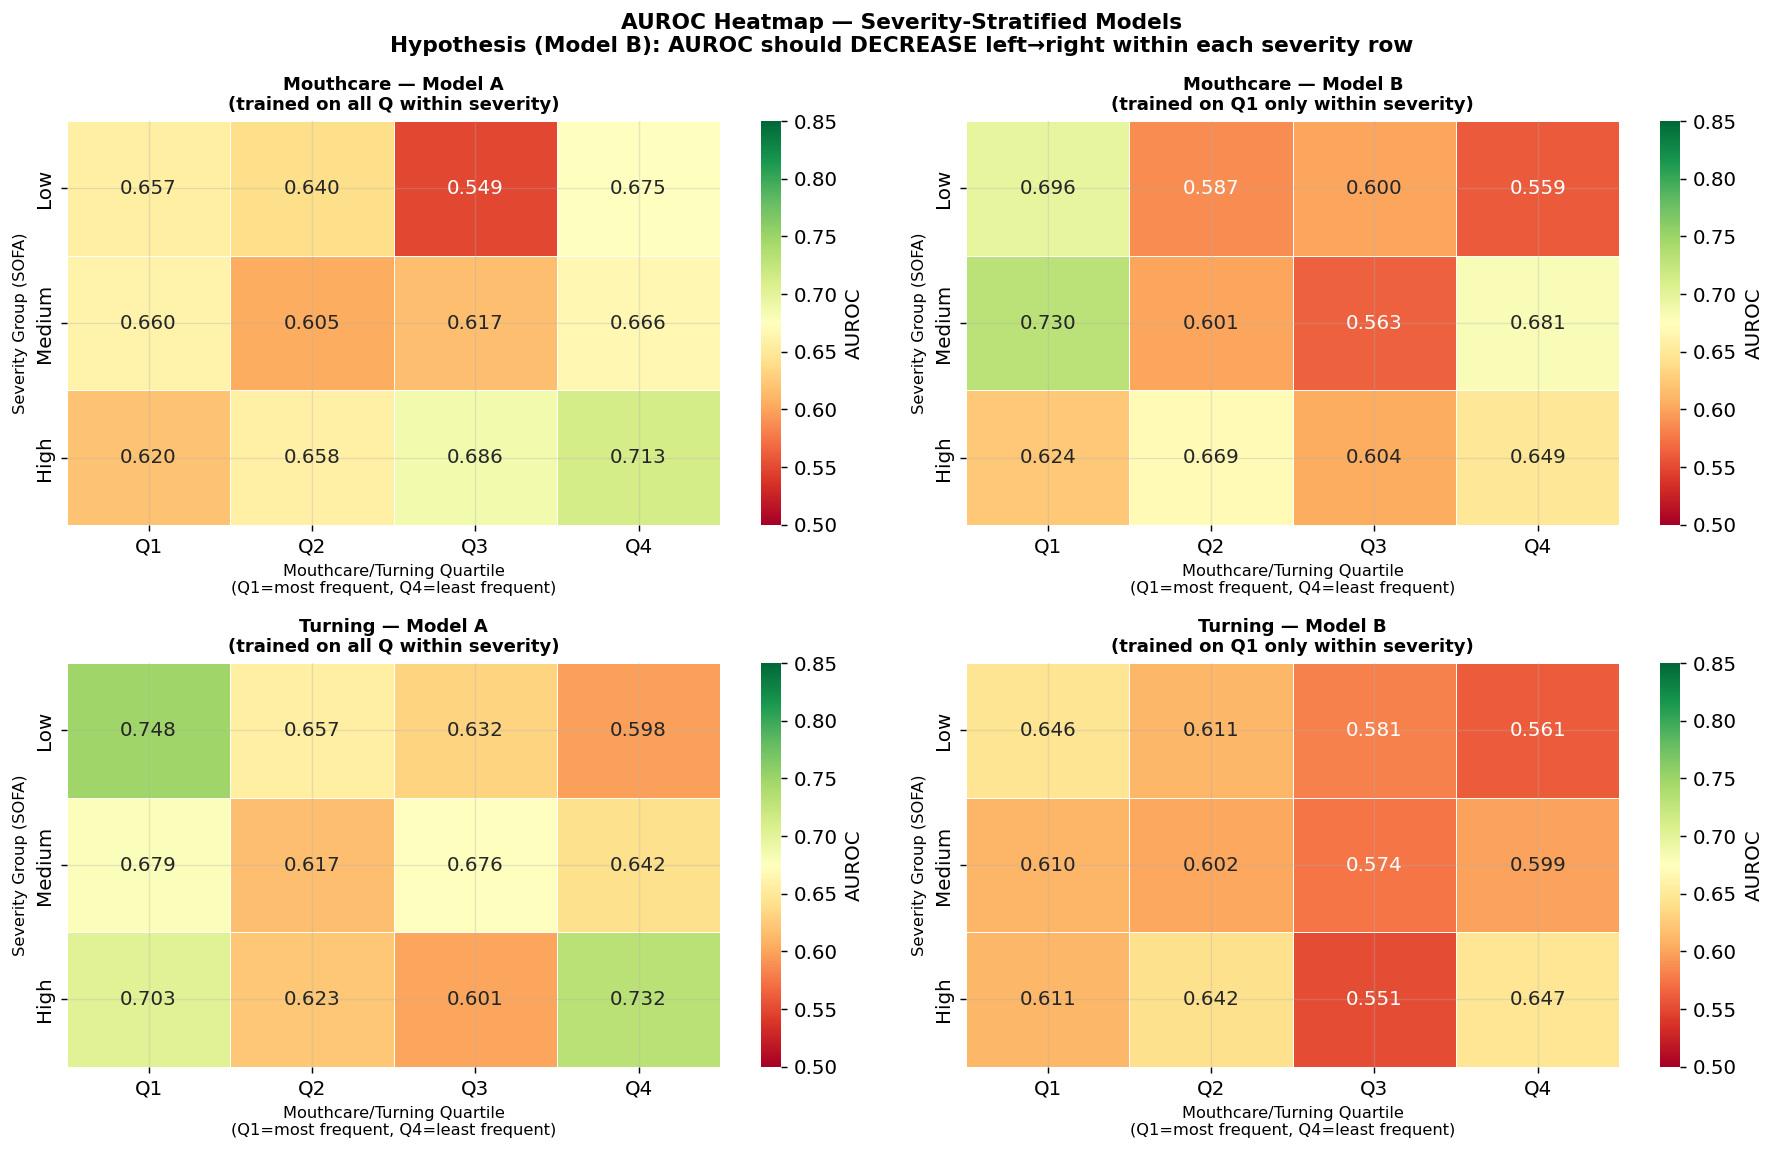

Saved: fig1_auc_heatmap.png


In [15]:
def auc_pivot(results_df, care_label, model_name):
    sub = results_df[
        (results_df['Care Type'] == care_label) &
        (results_df['Model'] == model_name)
    ].copy()
    sub['Q'] = sub['Test Set'].str.extract(r'(Q\d)')
    pivot = sub.pivot_table(index='Severity', columns='Q', values='AUROC', aggfunc='first')
    existing_q = [q for q in QUARTILES if q in pivot.columns]
    pivot = pivot[existing_q]
    pivot.index = pd.CategoricalIndex(pivot.index, categories=SEVERITY_LABELS, ordered=True)
    return pivot.sort_index()

fig, axes = plt.subplots(2, 2, figsize=(14, 9))
titles = [
    ('Mouthcare','A – All Quartiles','Mouthcare — Model A\n(trained on all Q within severity)'),
    ('Mouthcare','B – Q1 Only',      'Mouthcare — Model B\n(trained on Q1 only within severity)'),
    ('Turning',  'A – All Quartiles','Turning — Model A\n(trained on all Q within severity)'),
    ('Turning',  'B – Q1 Only',      'Turning — Model B\n(trained on Q1 only within severity)'),
]
for ax, (care, model, title) in zip(axes.flat, titles):
    try:
        piv = auc_pivot(results_df, care, model)
        sns.heatmap(piv.astype(float), annot=True, fmt='.3f',
                    cmap='RdYlGn', vmin=0.50, vmax=0.85,
                    ax=ax, linewidths=0.5, linecolor='white',
                    cbar_kws={'label':'AUROC'})
        ax.set_title(title, fontweight='bold', fontsize=10)
        ax.set_xlabel('Mouthcare/Turning Quartile\n(Q1=most frequent, Q4=least frequent)', fontsize=9)
        ax.set_ylabel('Severity Group (SOFA)', fontsize=9)
    except Exception as e:
        ax.text(0.5,0.5,f'No data\n{e}',ha='center',va='center',transform=ax.transAxes)

plt.suptitle('AUROC Heatmap — Severity-Stratified Models\n'
             'Hypothesis (Model B): AUROC should DECREASE left→right within each severity row',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER,'fig1_auc_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: fig1_auc_heatmap.png')

## 10. Discriminative Performance — AUROC with 95% Bootstrap Confidence Intervals

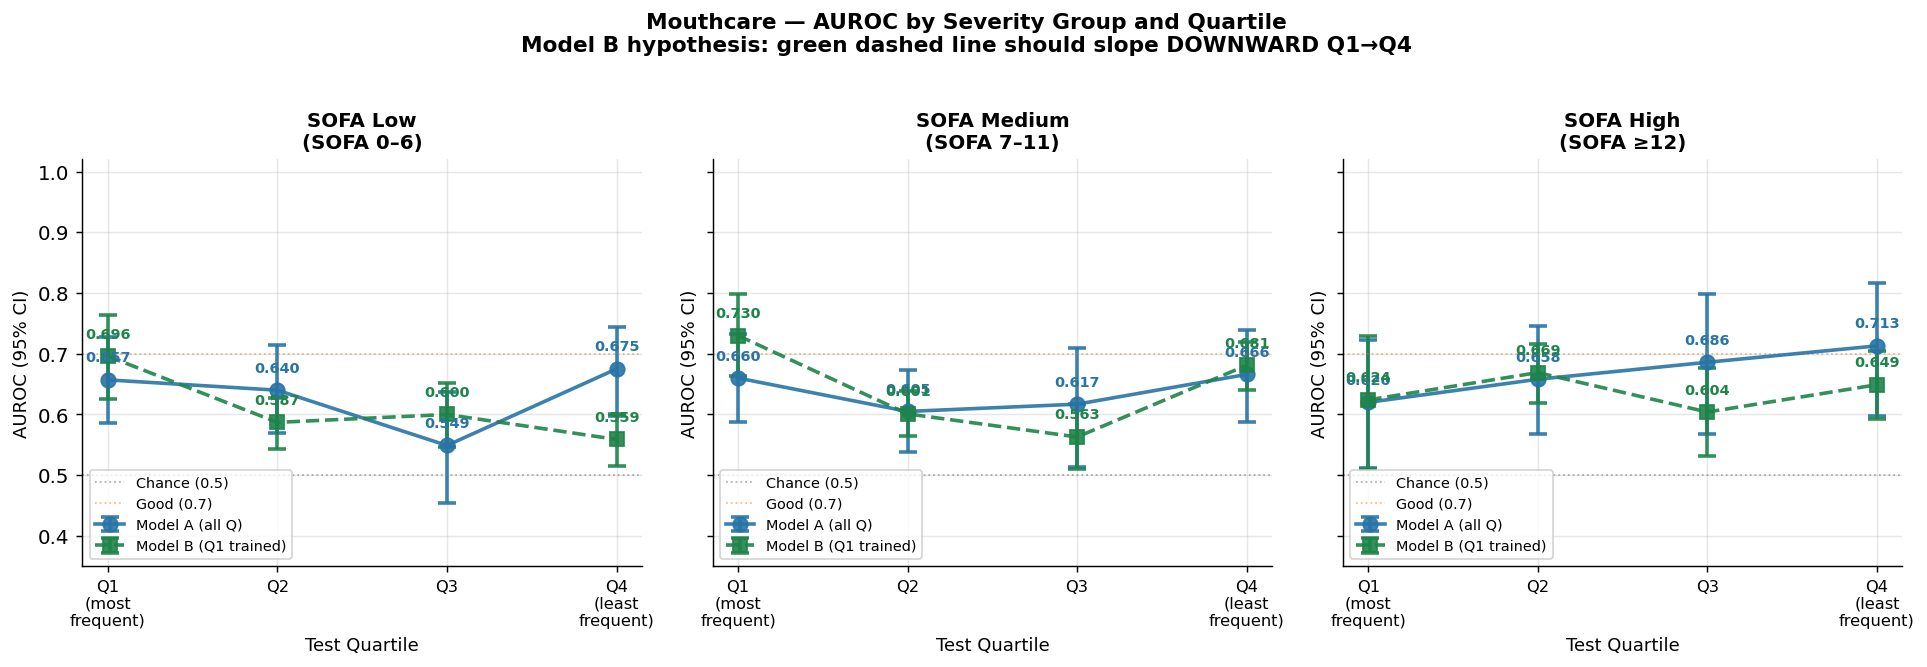

  Saved: figures/fig2a_auroc_mouthcare.png


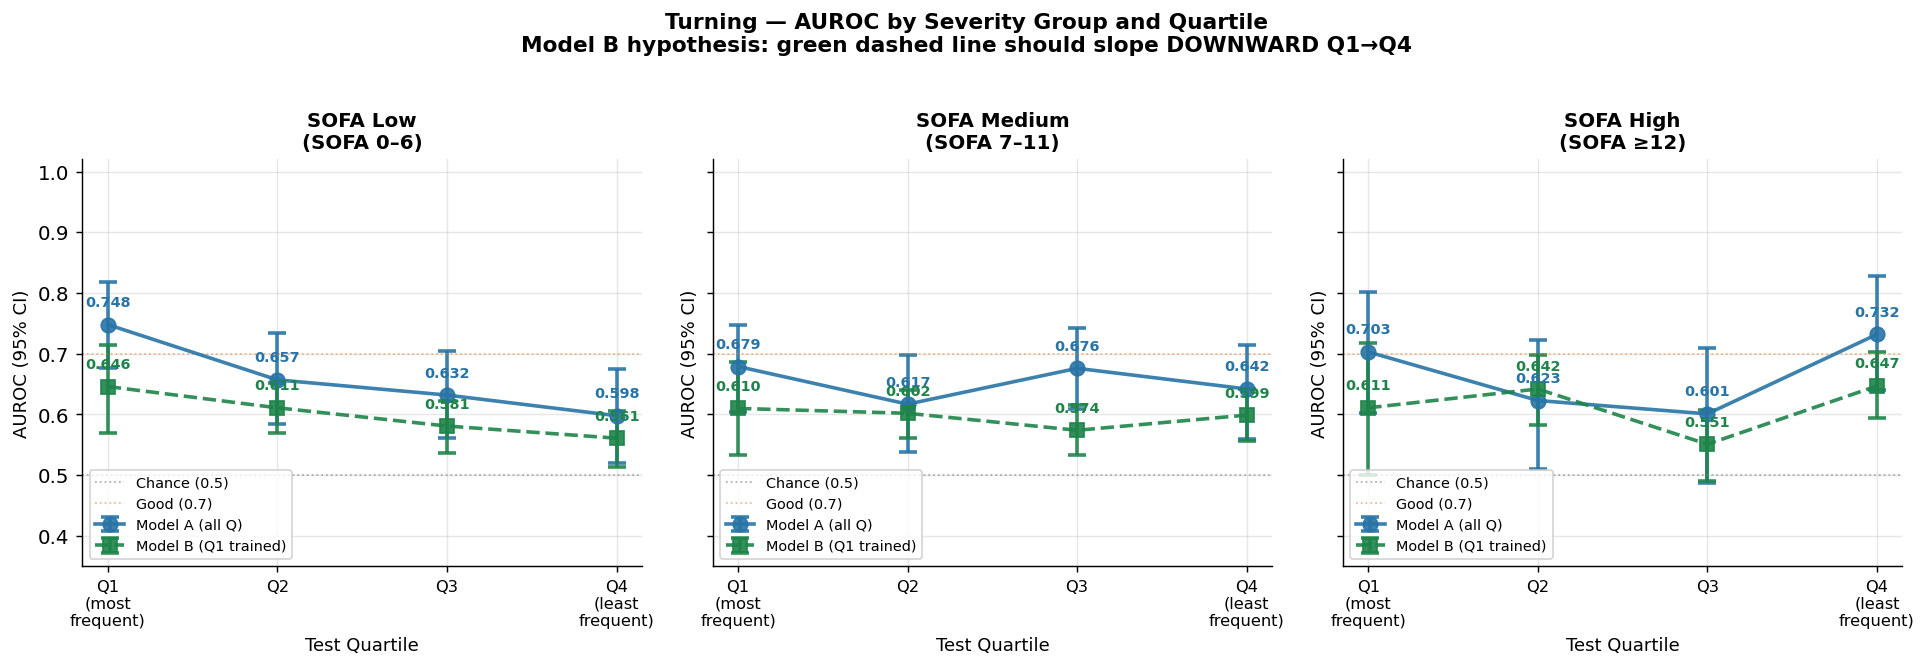

  Saved: figures/fig2b_auroc_turning.png


In [16]:
def plot_auroc_lines(results_df, care_label, save_path):
    sevs = SEVERITY_LABELS
    fig, axes = plt.subplots(1, len(sevs), figsize=(5*len(sevs), 5), sharey=True)

    for ax, sev in zip(axes, sevs):
        sub = results_df[
            (results_df['Care Type'] == care_label) &
            (results_df['Severity'] == sev)
        ]
        for mname, style in MODEL_STYLES.items():
            mdf = sub[sub['Model'] == mname].copy()
            mdf['Q'] = mdf['Test Set'].str.extract(r'(Q\d)')
            mdf = mdf.dropna(subset=['Q','AUROC']).sort_values('Q')
            if len(mdf) == 0:
                continue
            x    = np.arange(len(mdf))
            auc  = mdf['AUROC'].values.astype(float)
            lo   = mdf['AUROC_lo'].values.astype(float)
            hi   = mdf['AUROC_hi'].values.astype(float)
            yerr = np.array([auc-lo, hi-auc])
            ax.errorbar(x, auc, yerr=yerr,
                        color=style['color'], marker=style['marker'],
                        linestyle=style['ls'], linewidth=2, markersize=8,
                        capsize=5, capthick=2, label=style['label'],
                        ecolor=style['color'], alpha=0.9)
            for xi, ai in enumerate(auc):
                ax.annotate(f'{ai:.3f}', (xi,ai),
                            textcoords='offset points', xytext=(0,10),
                            ha='center', fontsize=8, color=style['color'], fontweight='bold')

        ax.axhline(0.5, color='grey', ls=':', lw=1, alpha=0.6, label='Chance (0.5)')
        ax.axhline(0.7, color='#E67E22', ls=':', lw=1, alpha=0.5, label='Good (0.7)')
        ax.set_xticks(range(len(QUARTILES)))
        ax.set_xticklabels(['Q1\n(most\nfrequent)','Q2','Q3','Q4\n(least\nfrequent)'], fontsize=9)
        ax.set_xlabel('Test Quartile', fontsize=10)
        ax.set_ylim(0.35, 1.02)
        ax.set_title(f'SOFA {sev}\n(SOFA {"0–6" if sev=="Low" else "7–11" if sev=="Medium" else "≥12"})',
                     fontweight='bold', fontsize=11)
        ax.set_ylabel('AUROC (95% CI)', fontsize=10)
        ax.legend(fontsize=8, loc='lower left')

    fig.suptitle(f'{care_label} — AUROC by Severity Group and Quartile\n'
                 f'Model B hypothesis: green dashed line should slope DOWNWARD Q1→Q4',
                 fontsize=12, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()
    print(f'  Saved: {save_path}')

plot_auroc_lines(results_df, 'Mouthcare',
                 os.path.join(OUTPUT_FOLDER,'fig2a_auroc_mouthcare.png'))
plot_auroc_lines(results_df, 'Turning',
                 os.path.join(OUTPUT_FOLDER,'fig2b_auroc_turning.png'))

## 11. Model Calibration Analysis

Calibration curves compare the model's predicted mortality probability against observed mortality rates in each quartile. For Model B, curves falling above the diagonal in Q3 and Q4 indicate systematic under-prediction of mortality risk — that is, the model assigns lower risk scores than patients actually experience. This pattern would indicate that low-care patients carry mortality risk not captured by clinical severity features alone, consistent with the study hypothesis.

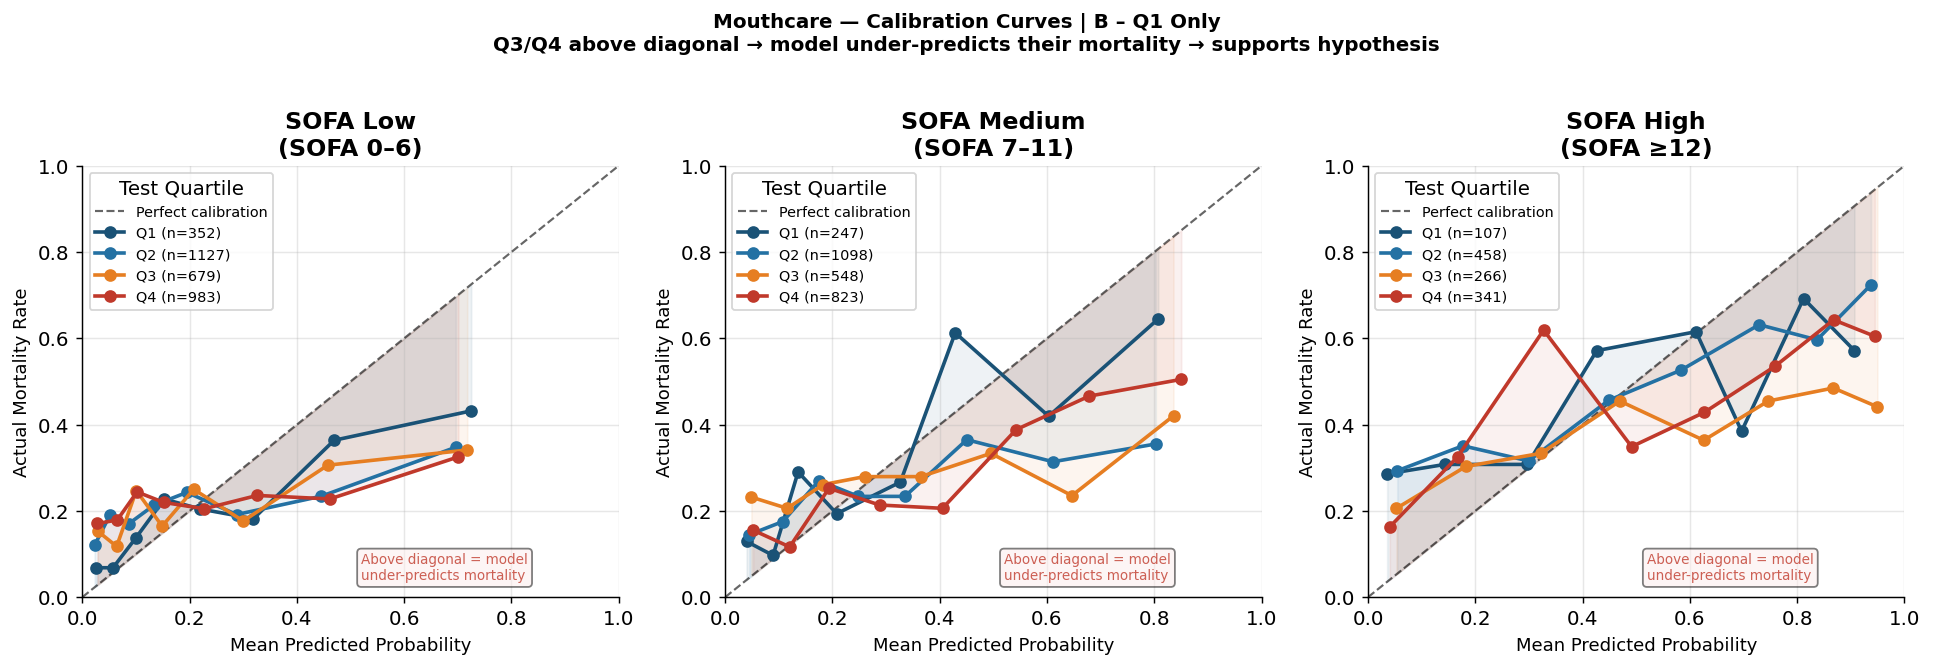

  Saved: figures/fig3_calibration_mouthcare_modelB.png


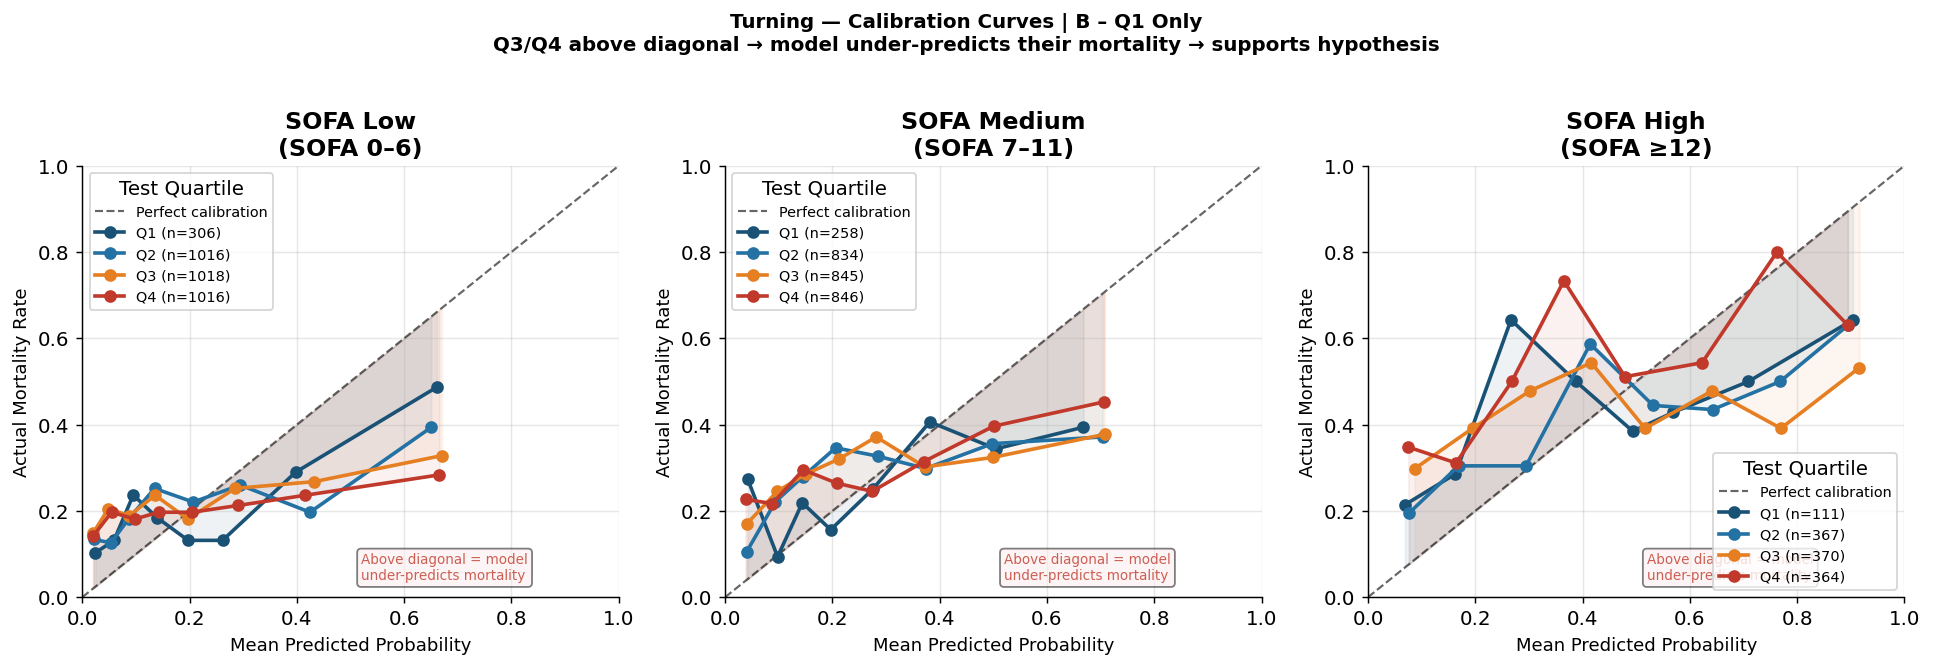

  Saved: figures/fig3_calibration_turning_modelB.png


In [17]:
def plot_calibration_grid(care_label, model_name, save_path):
    sevs = SEVERITY_LABELS
    fig, axes = plt.subplots(1, len(sevs), figsize=(5*len(sevs), 5))

    for ax, sev in zip(axes, sevs):
        entries = [(q,yt,yp) for (cl,sl,mn,q,yt,yp) in calibration_store
                   if cl==care_label and sl==sev and mn==model_name]
        ax.plot([0,1],[0,1],'k--', lw=1.2, label='Perfect calibration', alpha=0.6)
        for q, yt, yp in sorted(entries, key=lambda x: x[0]):
            if len(yt) < 20:
                continue
            try:
                fp, mp = calibration_curve(np.array(yt), np.array(yp),
                                           n_bins=8, strategy='quantile')
                col = Q_COLOURS.get(q,'grey')
                ax.plot(mp, fp, marker='o', lw=2, color=col,
                        label=f'{q} (n={len(yt)})', markersize=6)
                ax.fill_between(mp, mp, fp, alpha=0.07, color=col)
            except:
                pass
        ax.set_xlabel('Mean Predicted Probability', fontsize=10)
        ax.set_ylabel('Actual Mortality Rate', fontsize=10)
        ax.set_title(f'SOFA {sev}\n(SOFA {"0–6" if sev=="Low" else "7–11" if sev=="Medium" else "≥12"})',
                     fontweight='bold')
        ax.legend(title='Test Quartile', fontsize=8)
        ax.set_xlim(0,1); ax.set_ylim(0,1)
        ax.text(0.52,0.04,'Above diagonal = model\nunder-predicts mortality',
                fontsize=7.5,color='#C0392B',alpha=0.8,
                bbox=dict(boxstyle='round,pad=0.3',facecolor='#FDEDEC',alpha=0.5))

    fig.suptitle(f'{care_label} — Calibration Curves | {model_name}\n'
                 f'Q3/Q4 above diagonal → model under-predicts their mortality → supports hypothesis',
                 fontsize=11, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()
    print(f'  Saved: {save_path}')

for care in ['Mouthcare','Turning']:
    plot_calibration_grid(
        care, 'B – Q1 Only',
        os.path.join(OUTPUT_FOLDER, f'fig3_calibration_{care.lower()}_modelB.png')
    )

## 11b. Decision Curve Analysis

Decision curve analysis (DCA) evaluates the clinical usefulness of a prediction model across a range of probability thresholds. For each threshold, the **net benefit** of using the model to guide decisions is computed and compared to two reference strategies: **Treat None** (treat no one; net benefit = 0) and **Treat All** (treat everyone; net benefit = prevalence − (1−prevalence)×(pt/(1−pt)) where pt is the threshold). The model’s net benefit at threshold *pt* is (TP/*n*) − (FP/*n*)×(pt/(1−pt)), with classification as positive when predicted probability ≥ *pt*.

A model is clinically useful at a given threshold if its net benefit exceeds both Treat None and Treat All. For Model B, we expect net benefit to be highest when evaluated on Q1 (the population on which it was trained) and to decrease when applied to Q2–Q4, consistent with the hypothesis that care frequency influences outcome and that a model trained on high-frequency care generalises less well to lower-frequency care.

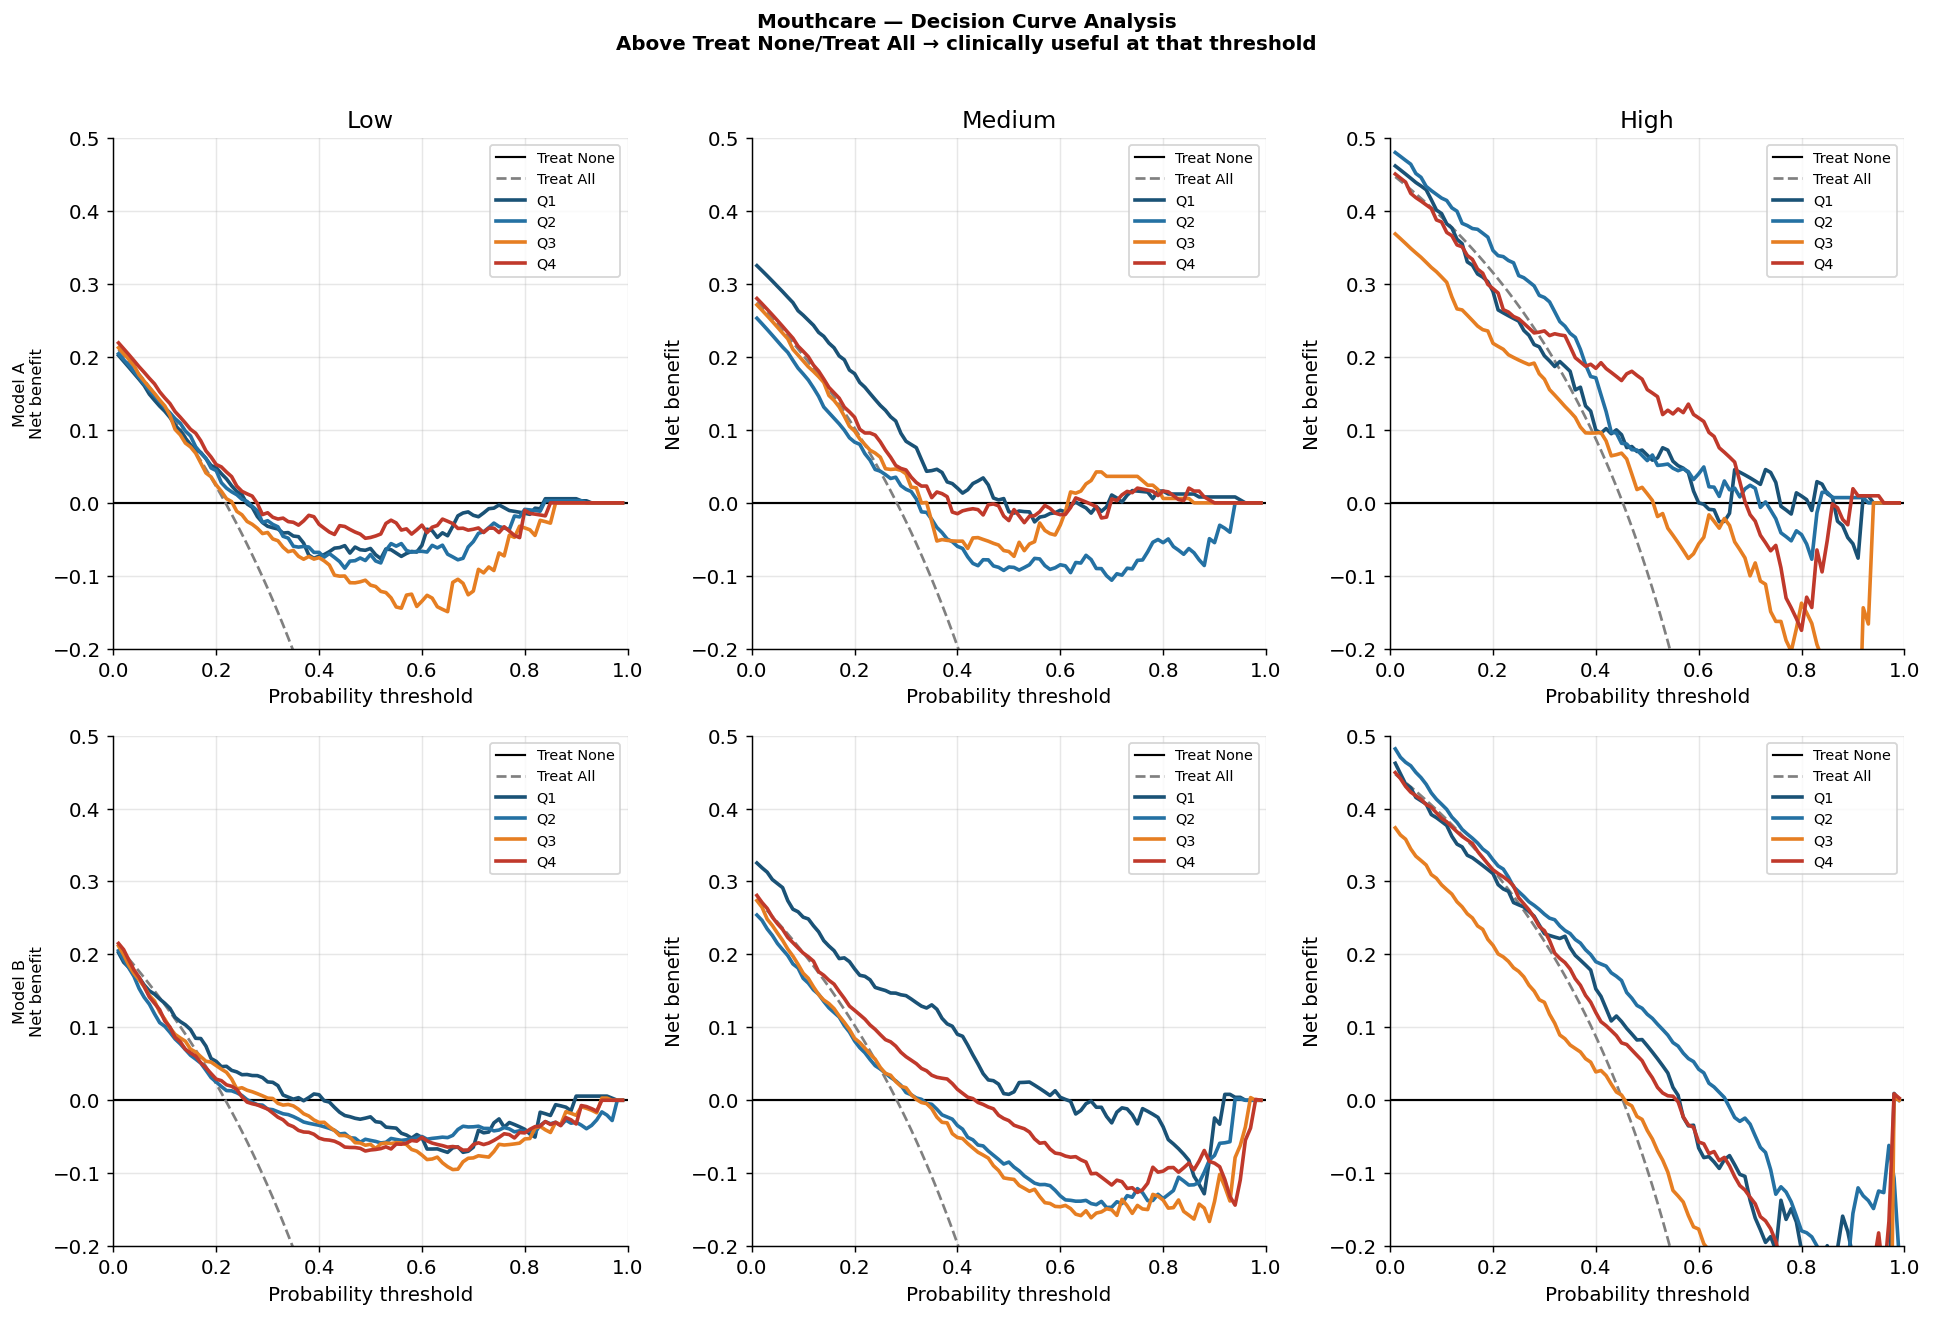

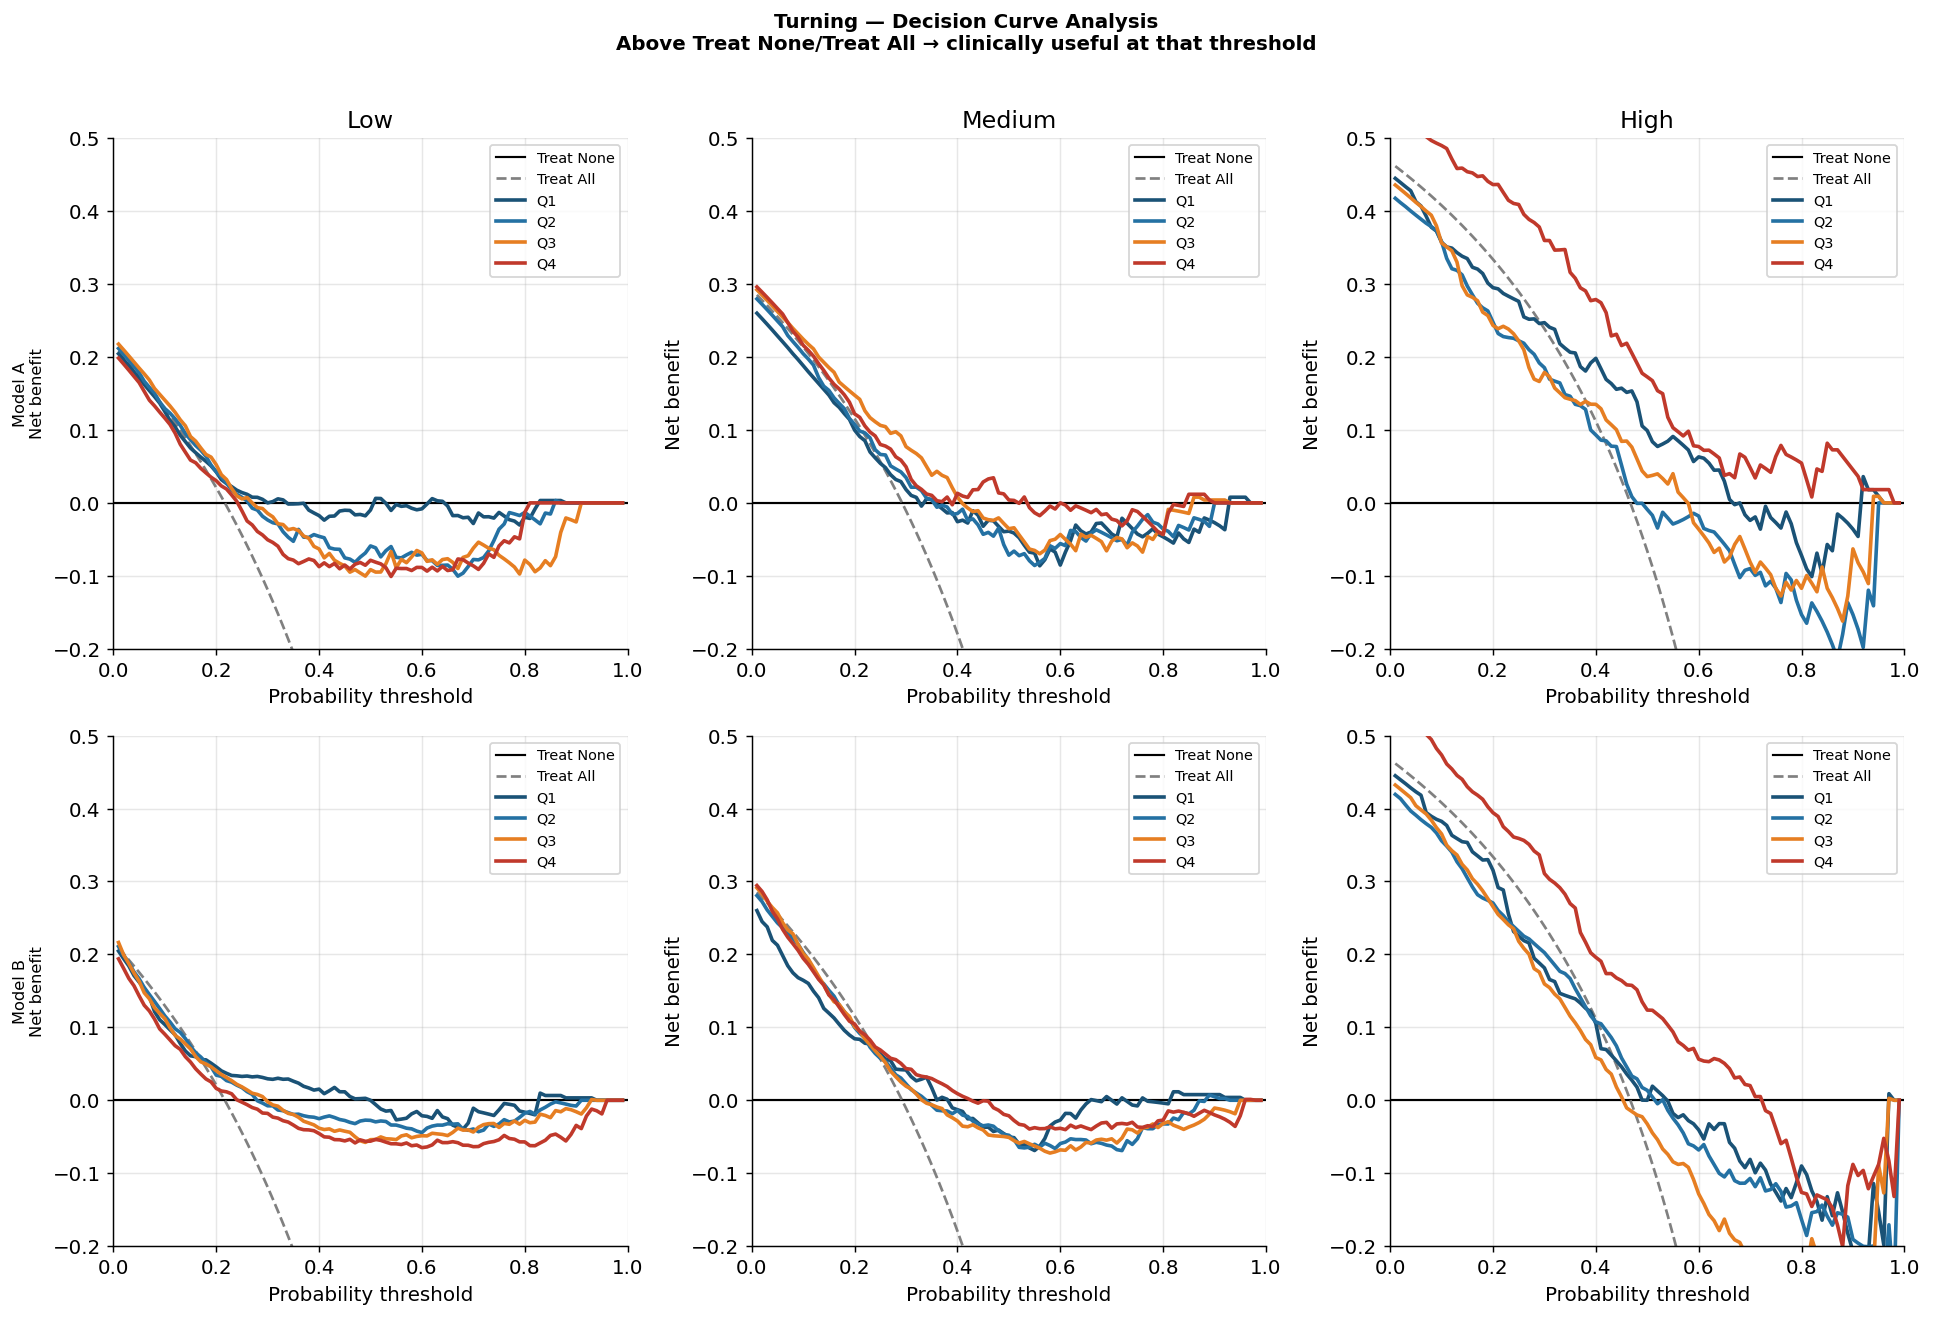

Saved: fig_dca_mouthcare.png, fig_dca_turning.png


In [28]:
def net_benefit(y_true, y_prob, pt):
    """Net benefit at probability threshold pt. NB = (TP/n) - (FP/n)*(pt/(1-pt))."""
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    n = len(y_true)
    if n == 0 or pt <= 0 or pt >= 1:
        return np.nan
    pred_positive = (y_prob >= pt).astype(int)
    tp = ((pred_positive == 1) & (y_true == 1)).sum()
    fp = ((pred_positive == 1) & (y_true == 0)).sum()
    nb = (tp / n) - (fp / n) * (pt / (1 - pt))
    return nb


def treat_all_net_benefit(prevalence, pt):
    """Net benefit of 'Treat All' at threshold pt: prevalence - (1-prevalence)*(pt/(1-pt))."""
    if pt <= 0 or pt >= 1:
        return np.nan
    return prevalence - (1 - prevalence) * (pt / (1 - pt))


def plot_dca_grid(care_label, save_path, thresholds=None):
    """Plot DCA in a 2×3 grid: row 0 = Model A (Low/Medium/High severity), row 1 = Model B.
    Each panel: Treat None, Treat All, and net benefit per quartile (Q1–Q4) for that model only."""
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 99)
    sevs = SEVERITY_LABELS
    model_specs = [
        ('A – All Quartiles', 'Model A'),
        ('B – Q1 Only', 'Model B'),
    ]
    fig, axes = plt.subplots(2, len(sevs), figsize=(5 * len(sevs), 5 * 2))
    for col, sev in enumerate(sevs):
        entries_a = [(q, yt, yp) for (cl, sl, mn, q, yt, yp) in calibration_store
                     if cl == care_label and sl == sev and mn == 'A – All Quartiles']
        entries_b = [(q, yt, yp) for (cl, sl, mn, q, yt, yp) in calibration_store
                     if cl == care_label and sl == sev and mn == 'B – Q1 Only']
        all_yt = np.concatenate([np.asarray(yt) for (q, yt, yp) in entries_a + entries_b]) if (entries_a or entries_b) else np.array([0])
        prev = all_yt.mean() if len(all_yt) > 0 else 0.0
        nb_treat_all = [treat_all_net_benefit(prev, pt) for pt in thresholds]
        for row, (model_name, row_label) in enumerate(model_specs):
            ax = axes[row, col]
            ax.axhline(0, color='black', linestyle='-', lw=1.2, label='Treat None')
            ax.plot(thresholds, nb_treat_all, color='gray', linestyle='--', lw=1.5, label='Treat All')
            entries = entries_a if row == 0 else entries_b
            for q, yt, yp in sorted(entries, key=lambda x: x[0]):
                nb_curve = [net_benefit(yt, yp, pt) for pt in thresholds]
                col_q = Q_COLOURS.get(q, 'grey')
                ax.plot(thresholds, nb_curve, color=col_q, lw=2, label=q)
            ax.set_xlim(0, 1)
            ax.set_ylim(-0.2, 0.5)
            ax.set_xlabel('Probability threshold')
            ax.set_ylabel('Net benefit')
            if row == 0:
                ax.set_title(sev)
            ax.legend(loc='upper right', fontsize=8)
            if col == 0:
                ax.set_ylabel(f'{row_label}\nNet benefit', fontsize=9)
    fig.suptitle(f'{care_label} — Decision Curve Analysis\n'
                 'Above Treat None/Treat All → clinically useful at that threshold',
                 fontsize=11, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()


for care in ['Mouthcare', 'Turning']:
    plot_dca_grid(care, os.path.join(OUTPUT_FOLDER, f'fig_dca_{care.lower()}.png'))
print('Saved: fig_dca_mouthcare.png, fig_dca_turning.png')

## 12b. Calibration Quality — Brier Score Analysis

For each severity stratum and model (Model A and Model B), the Brier score is computed on each test quartile (Q1–Q4) using predicted probabilities. Bootstrap resampling (1,000 iterations) is used to derive 95% confidence intervals.

The Brier score measures mean squared error between predicted probabilities and actual binary outcomes, ranging from 0 (perfect) to 1 (worst). A score of 0.25 corresponds to uninformative prediction at 50% prevalence. Lower values indicate better probabilistic calibration.

For the study hypothesis, Model B is expected to show increasing Brier scores when generalised from Q1 to Q2–Q4, reflecting progressively poorer probability calibration among patients receiving less frequent care.

Brier Score Summary Table
care_type severity_group        model_type test_quartile    N  mortality_pct brier_score ci_lower ci_upper
Mouthcare            Low A – All Quartiles            Q1  352           21.0      0.1849   0.1671   0.2040
Mouthcare            Low A – All Quartiles            Q2  339           21.2      0.1913   0.1726   0.2111
Mouthcare            Low A – All Quartiles            Q3  204           22.1      0.2182   0.1911   0.2464
Mouthcare            Low A – All Quartiles            Q4  295           22.7      0.1861   0.1667   0.2067
Mouthcare            Low       B – Q1 Only            Q1  352           21.0      0.1673   0.1449   0.1946
Mouthcare            Low       B – Q1 Only            Q2 1127           21.4      0.1919   0.1756   0.2086
Mouthcare            Low       B – Q1 Only            Q3  679           21.9      0.1950   0.1747   0.2160
Mouthcare            Low       B – Q1 Only            Q4  983           22.6      0.2063   0.1903   0.2228
Mouthcare  

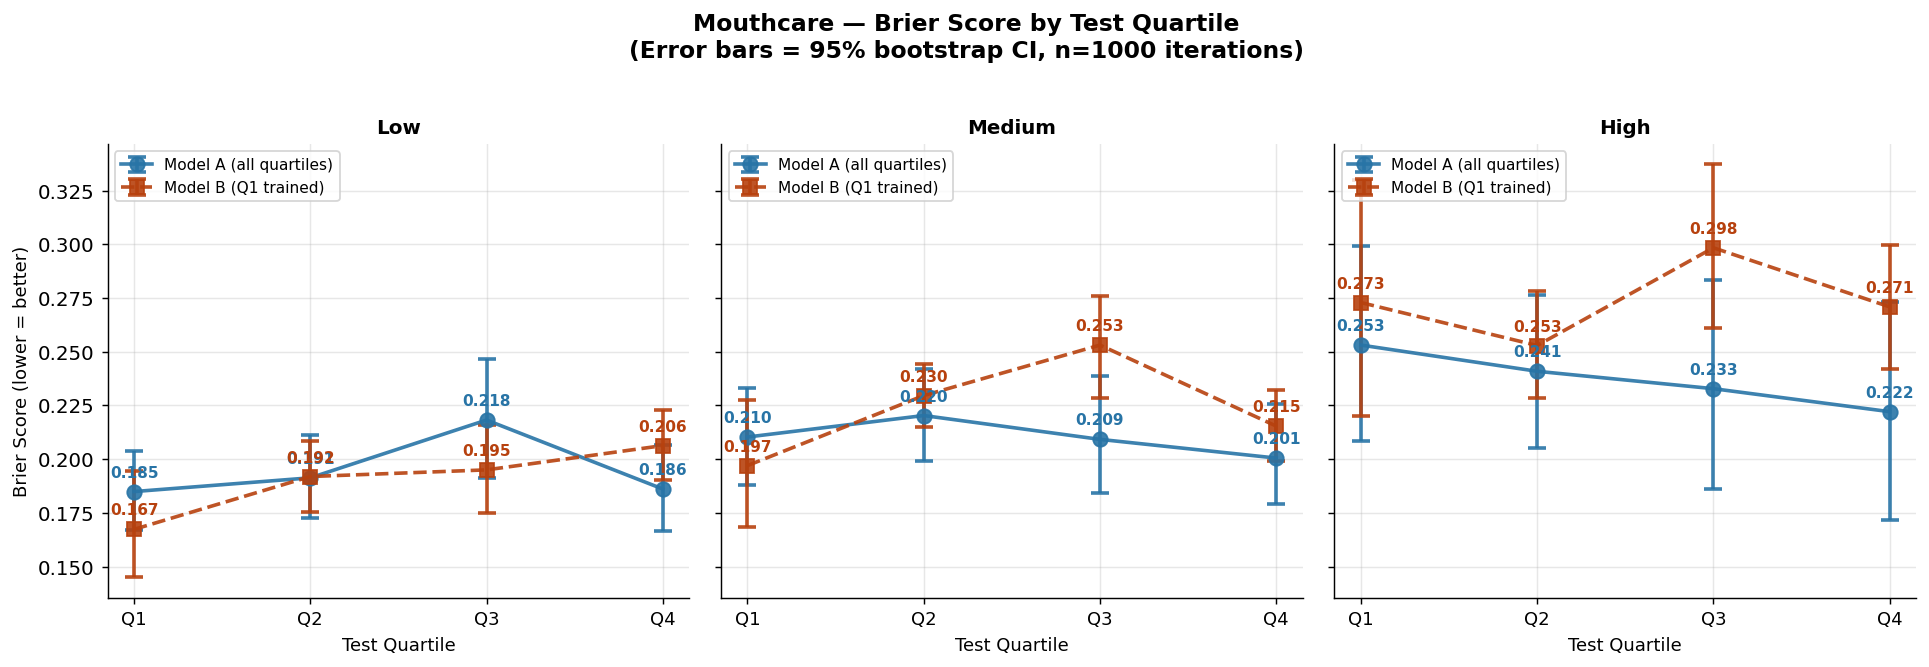

Saved: figures/fig_brier_mouthcare.png


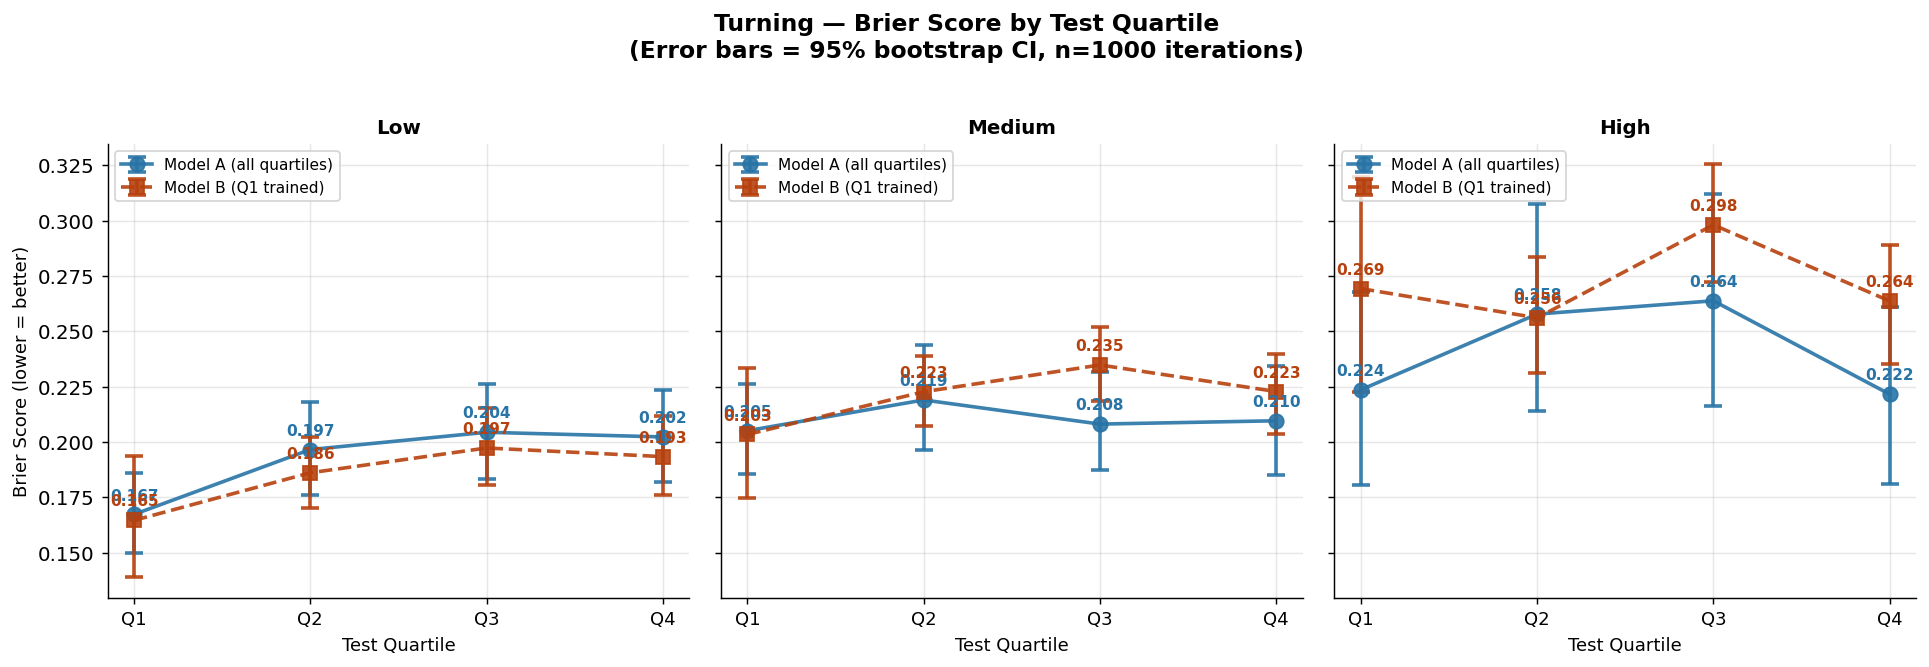

Saved: figures/fig_brier_turning.png


In [18]:
# ── Brier Score Analysis ─────────────────────────────────────────────────────
# Uses calibration_store: list of (care, severity, model, quartile, y_true, y_prob)
# Computes Brier score from predicted probabilities with 1000-iteration bootstrap CI.

from sklearn.metrics import brier_score_loss

def bootstrap_brier(y_true, y_prob, n=1000, seed=42):
    """
    Bootstrap 95% CI for Brier score.
    Uses predicted probabilities directly (not class labels).
    Lower Brier score = better calibration.
    """
    rng      = np.random.default_rng(seed)
    y_true_a = np.array(y_true)
    y_prob_a = np.array(y_prob)
    idx      = np.arange(len(y_true_a))
    scores   = []
    for _ in range(n):
        b = rng.choice(idx, size=len(idx), replace=True)
        if len(np.unique(y_true_a[b])) < 2:
            continue
        scores.append(brier_score_loss(y_true_a[b], y_prob_a[b]))
    if not scores:
        return np.nan, np.nan, np.nan
    return np.mean(scores), np.percentile(scores, 2.5), np.percentile(scores, 97.5)


# ── Build tidy results dataframe ──────────────────────────────────────────────
brier_rows = []
for (care, severity, model, quartile, y_true, y_prob) in calibration_store:
    if len(y_true) < 10:
        continue
    bs, lo, hi = bootstrap_brier(y_true, y_prob)
    brier_rows.append({
        'care_type':      care,
        'severity_group': severity,
        'model_type':     model,
        'test_quartile':  quartile,
        'N':              len(y_true),
        'mortality_pct':  round(np.mean(y_true) * 100, 1),
        'brier_score':    round(bs, 4),
        'ci_lower':       round(lo, 4),
        'ci_upper':       round(hi, 4),
    })

brier_df = pd.DataFrame(brier_rows)

# ── Summary table ─────────────────────────────────────────────────────────────
print('Brier Score Summary Table')
print('=' * 90)
summary = brier_df[[
    'care_type','severity_group','model_type','test_quartile',
    'N','mortality_pct','brier_score','ci_lower','ci_upper'
]].copy()
summary['brier_score'] = summary['brier_score'].map('{:.4f}'.format)
summary['ci_lower']    = summary['ci_lower'].map('{:.4f}'.format)
summary['ci_upper']    = summary['ci_upper'].map('{:.4f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.max_rows', 200)
print(summary.to_string(index=False))


# ── Plot: Brier score with bootstrap CI error bars ────────────────────────────
def plot_brier(brier_df, care_label, save_path):
    df   = brier_df[brier_df['care_type'] == care_label].copy()
    sevs = [s for s in SEVERITY_LABELS if s in df['severity_group'].values]
    if not sevs:
        print(f'No Brier data for {care_label}')
        return

    fig, axes = plt.subplots(1, len(sevs), figsize=(5 * len(sevs), 5), sharey=True)
    if len(sevs) == 1:
        axes = [axes]

    styles = {
        'A – All Quartiles': {'color':'#2874A6','marker':'o','ls':'-',
                              'label':'Model A (all quartiles)'},
        'B – Q1 Only':       {'color':'#B7410E','marker':'s','ls':'--',
                              'label':'Model B (Q1 trained)'},
    }

    for ax, sev in zip(axes, sevs):
        sub = df[df['severity_group'] == sev]
        for mname, style in styles.items():
            mdf = sub[sub['model_type'] == mname].sort_values('test_quartile')
            if len(mdf) == 0:
                continue
            x    = np.arange(len(mdf))
            bm   = mdf['brier_score'].values.astype(float)
            lo   = mdf['ci_lower'].values.astype(float)
            hi   = mdf['ci_upper'].values.astype(float)
            yerr = np.array([bm - lo, hi - bm])
            ax.errorbar(x, bm, yerr=yerr,
                        color=style['color'], marker=style['marker'],
                        linestyle=style['ls'], linewidth=2, markersize=8,
                        capsize=5, capthick=2, label=style['label'],
                        ecolor=style['color'], alpha=0.9)
            for xi, bi in enumerate(bm):
                ax.annotate(f'{bi:.3f}', (xi, bi),
                            textcoords='offset points', xytext=(0, 8),
                            ha='center', fontsize=8.5,
                            color=style['color'], fontweight='bold')

        ax.set_xticks(range(len(QUARTILES)))
        ax.set_xticklabels(QUARTILES, fontsize=10)
        ax.set_xlabel('Test Quartile', fontsize=10)
        ax.set_title(sev, fontweight='bold', fontsize=11)
        if ax == axes[0]:
            ax.set_ylabel('Brier Score (lower = better)', fontsize=10)
        ax.legend(fontsize=8.5, loc='upper left')

    fig.suptitle(
        f'{care_label} — Brier Score by Test Quartile\n'
        f'(Error bars = 95% bootstrap CI, n=1000 iterations)',
        fontsize=13, fontweight='bold', y=1.02
    )
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()
    print(f'Saved: {save_path}')


for care in ['Mouthcare', 'Turning']:
    plot_brier(
        brier_df, care,
        os.path.join(OUTPUT_FOLDER, f'fig_brier_{care.lower()}.png')
    )


## 12c. Decision Curve Analysis — Recalibrated (Isotonic Regression)

Predicted probabilities from the XGBoost models are recalibrated using **isotonic regression** (fit on the same test set for illustration; for formal evaluation a held-out calibration set would be used). The recalibrated probabilities are then used to plot decision curve analysis in the same 2×3 grid as in Section 11b (Model A top row, Model B bottom row; columns = Low / Medium / High severity). Comparing these curves to the uncalibrated DCA highlights the effect of probability calibration on net benefit.

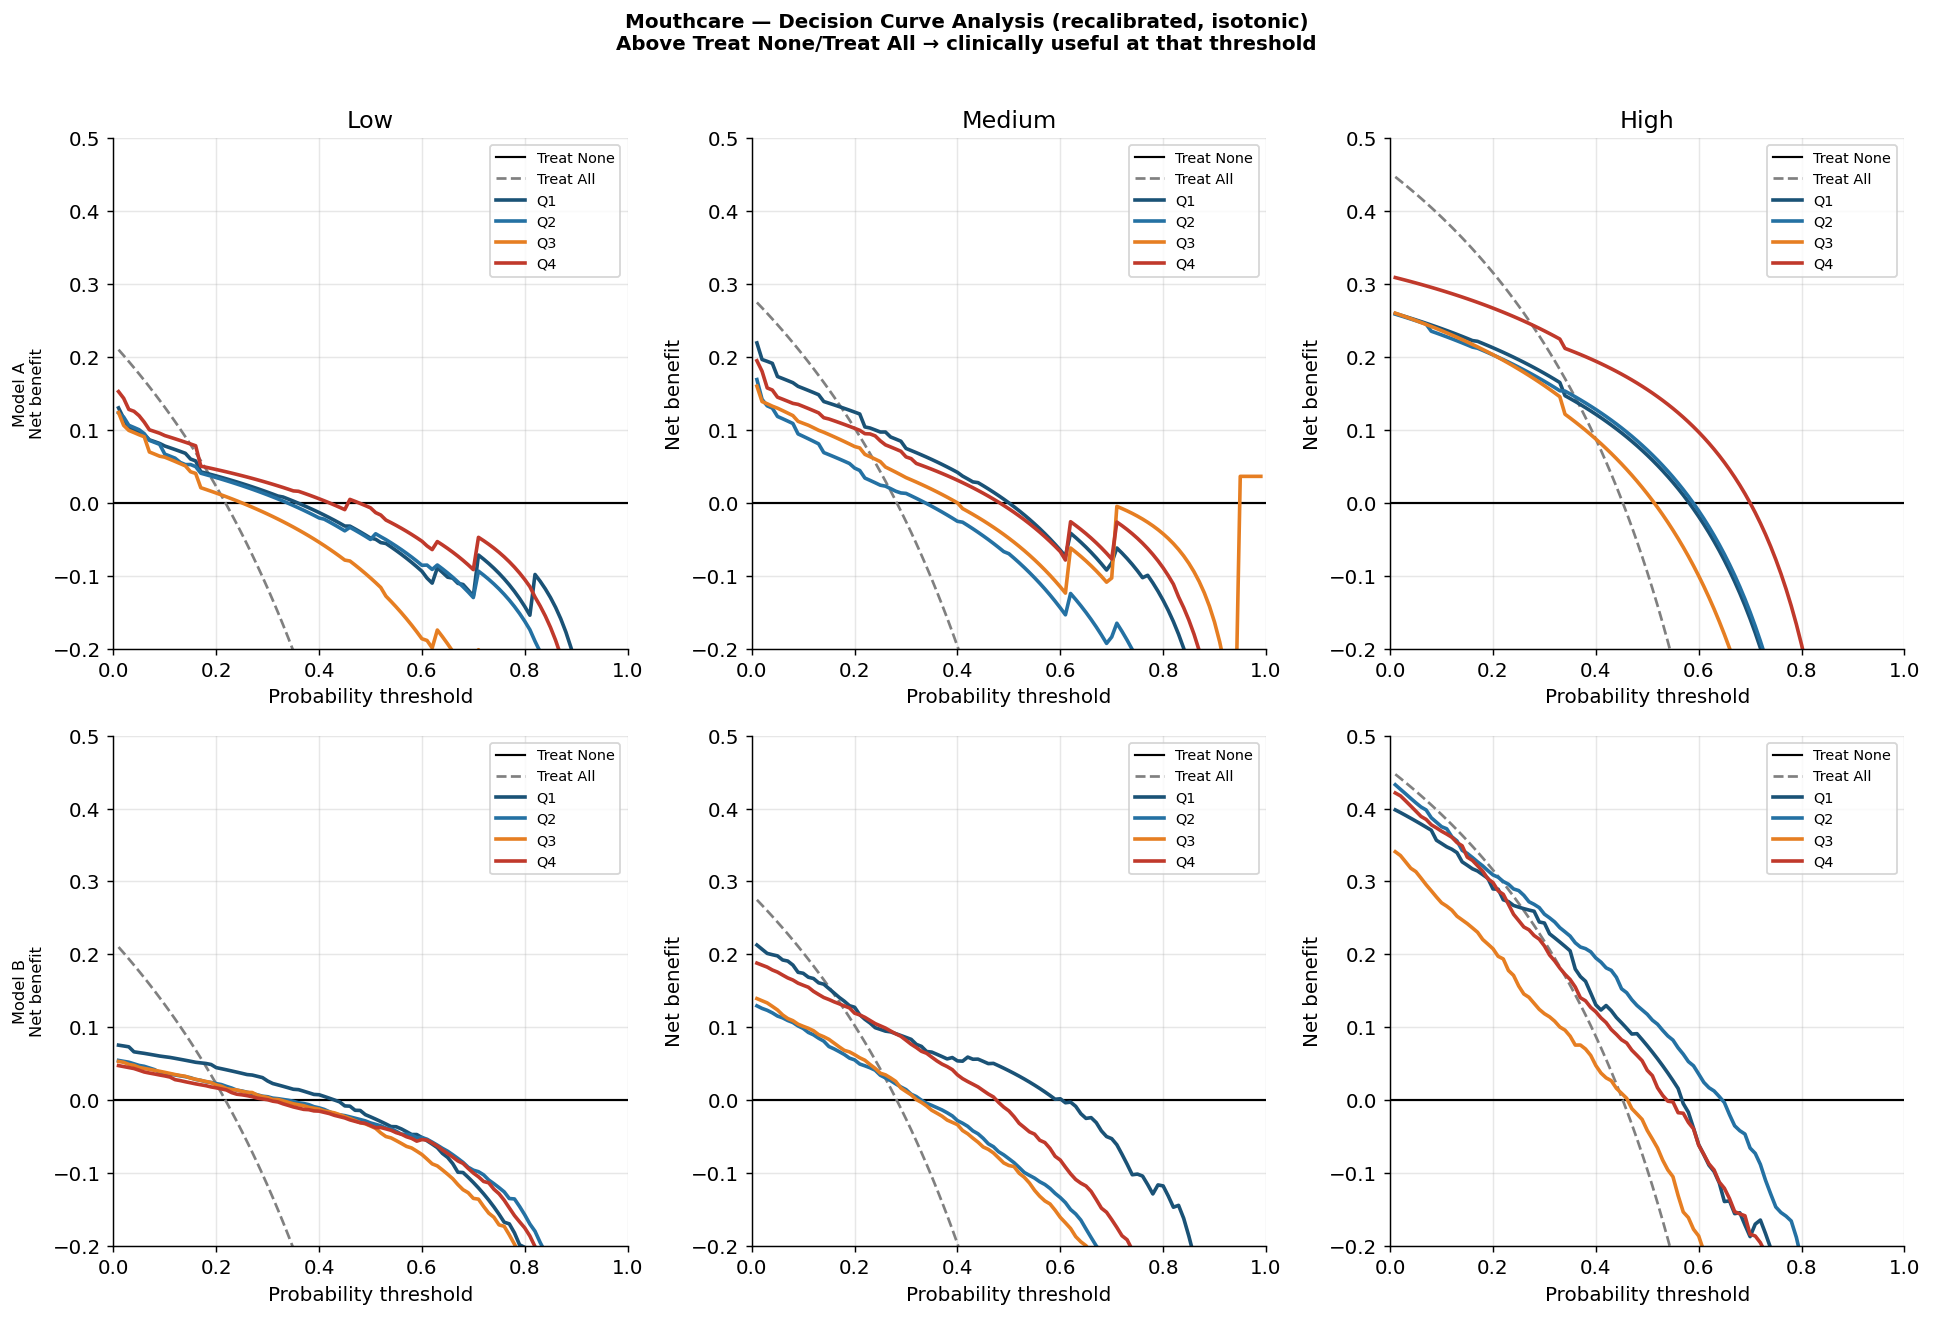

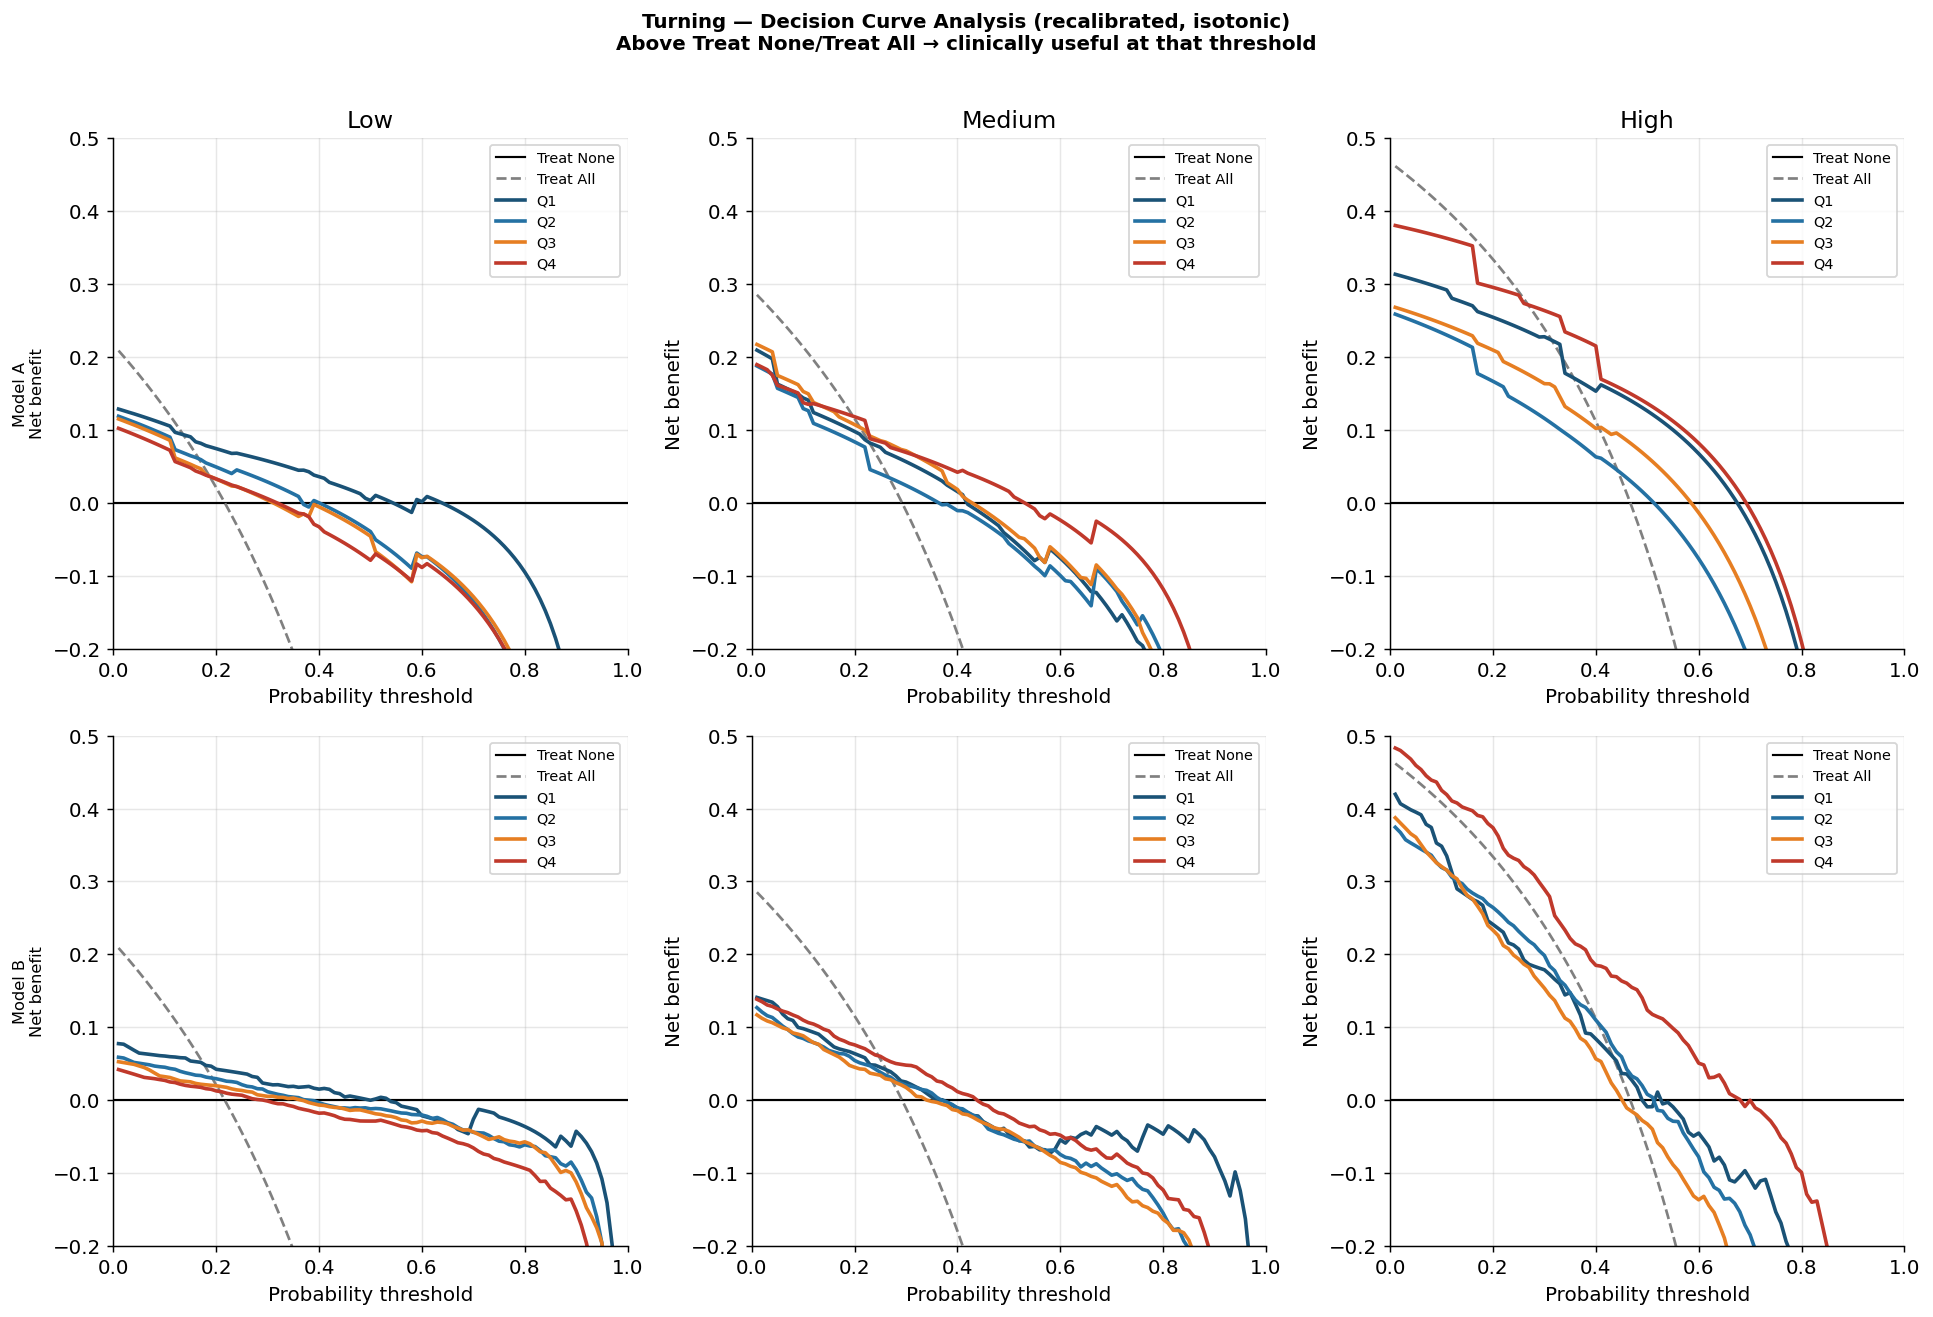

Saved: fig_dca_mouthcare_recal.png, fig_dca_turning_recal.png


In [30]:
from sklearn.isotonic import IsotonicRegression

# Build recalibrated store: for each (care, severity, model, quartile, y_true, y_prob),
# fit isotonic regression on (y_prob, y_true) and replace y_prob with recalibrated values.
calibration_store_recal = []
for (care, severity, model, quartile, yt, yp) in calibration_store:
    yt = np.asarray(yt)
    yp = np.asarray(yp)
    if len(yt) < 10 or len(np.unique(yt)) < 2:
        calibration_store_recal.append((care, severity, model, quartile, yt, yp))
        continue
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(yp.reshape(-1, 1), yt)
    yp_recal = np.clip(ir.predict(yp.reshape(-1, 1)), 0.0, 1.0)
    calibration_store_recal.append((care, severity, model, quartile, yt, yp_recal))


def plot_dca_grid_from_store(care_label, save_path, store, thresholds=None, title_suffix=''):
    """Same 2×3 DCA grid as plot_dca_grid but using a provided store (e.g. recalibrated)."""
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 99)
    sevs = SEVERITY_LABELS
    model_specs = [('A – All Quartiles', 'Model A'), ('B – Q1 Only', 'Model B')]
    fig, axes = plt.subplots(2, len(sevs), figsize=(5 * len(sevs), 5 * 2))
    for col, sev in enumerate(sevs):
        entries_a = [(q, yt, yp) for (cl, sl, mn, q, yt, yp) in store
                     if cl == care_label and sl == sev and mn == 'A – All Quartiles']
        entries_b = [(q, yt, yp) for (cl, sl, mn, q, yt, yp) in store
                     if cl == care_label and sl == sev and mn == 'B – Q1 Only']
        all_yt = np.concatenate([np.asarray(yt) for (q, yt, yp) in entries_a + entries_b]) if (entries_a or entries_b) else np.array([0])
        prev = all_yt.mean() if len(all_yt) > 0 else 0.0
        nb_treat_all = [treat_all_net_benefit(prev, pt) for pt in thresholds]
        for row, (model_name, row_label) in enumerate(model_specs):
            ax = axes[row, col]
            ax.axhline(0, color='black', linestyle='-', lw=1.2, label='Treat None')
            ax.plot(thresholds, nb_treat_all, color='gray', linestyle='--', lw=1.5, label='Treat All')
            entries = entries_a if row == 0 else entries_b
            for q, yt, yp in sorted(entries, key=lambda x: x[0]):
                nb_curve = [net_benefit(yt, yp, pt) for pt in thresholds]
                col_q = Q_COLOURS.get(q, 'grey')
                ax.plot(thresholds, nb_curve, color=col_q, lw=2, label=q)
            ax.set_xlim(0, 1)
            ax.set_ylim(-0.2, 0.5)
            ax.set_xlabel('Probability threshold')
            ax.set_ylabel('Net benefit')
            if row == 0:
                ax.set_title(sev)
            ax.legend(loc='upper right', fontsize=8)
            if col == 0:
                ax.set_ylabel(f'{row_label}\nNet benefit', fontsize=9)
    fig.suptitle(f'{care_label} — Decision Curve Analysis {title_suffix}\n'
                 'Above Treat None/Treat All → clinically useful at that threshold',
                 fontsize=11, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()


for care in ['Mouthcare', 'Turning']:
    plot_dca_grid_from_store(
        care,
        os.path.join(OUTPUT_FOLDER, f'fig_dca_{care.lower()}_recal.png'),
        calibration_store_recal,
        title_suffix='(recalibrated, isotonic)'
    )
print('Saved: fig_dca_mouthcare_recal.png, fig_dca_turning_recal.png')

## 12. Feature Importance — SHAP Analysis

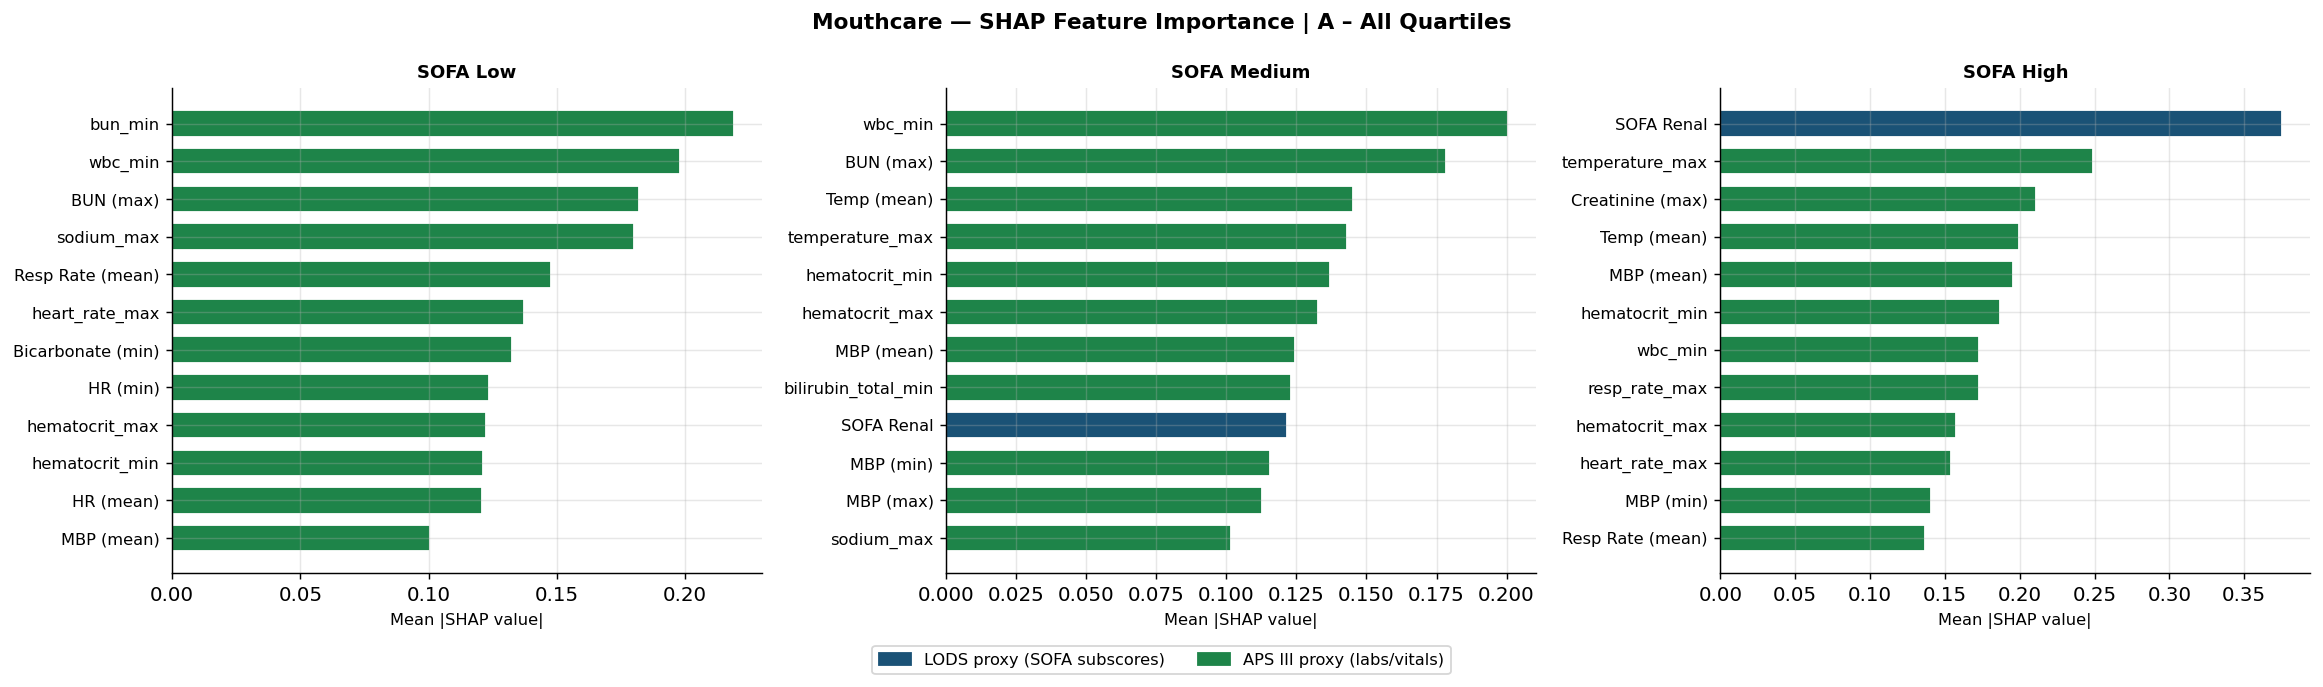

  Saved: figures/fig4_shap_mouthcare_modelA.png


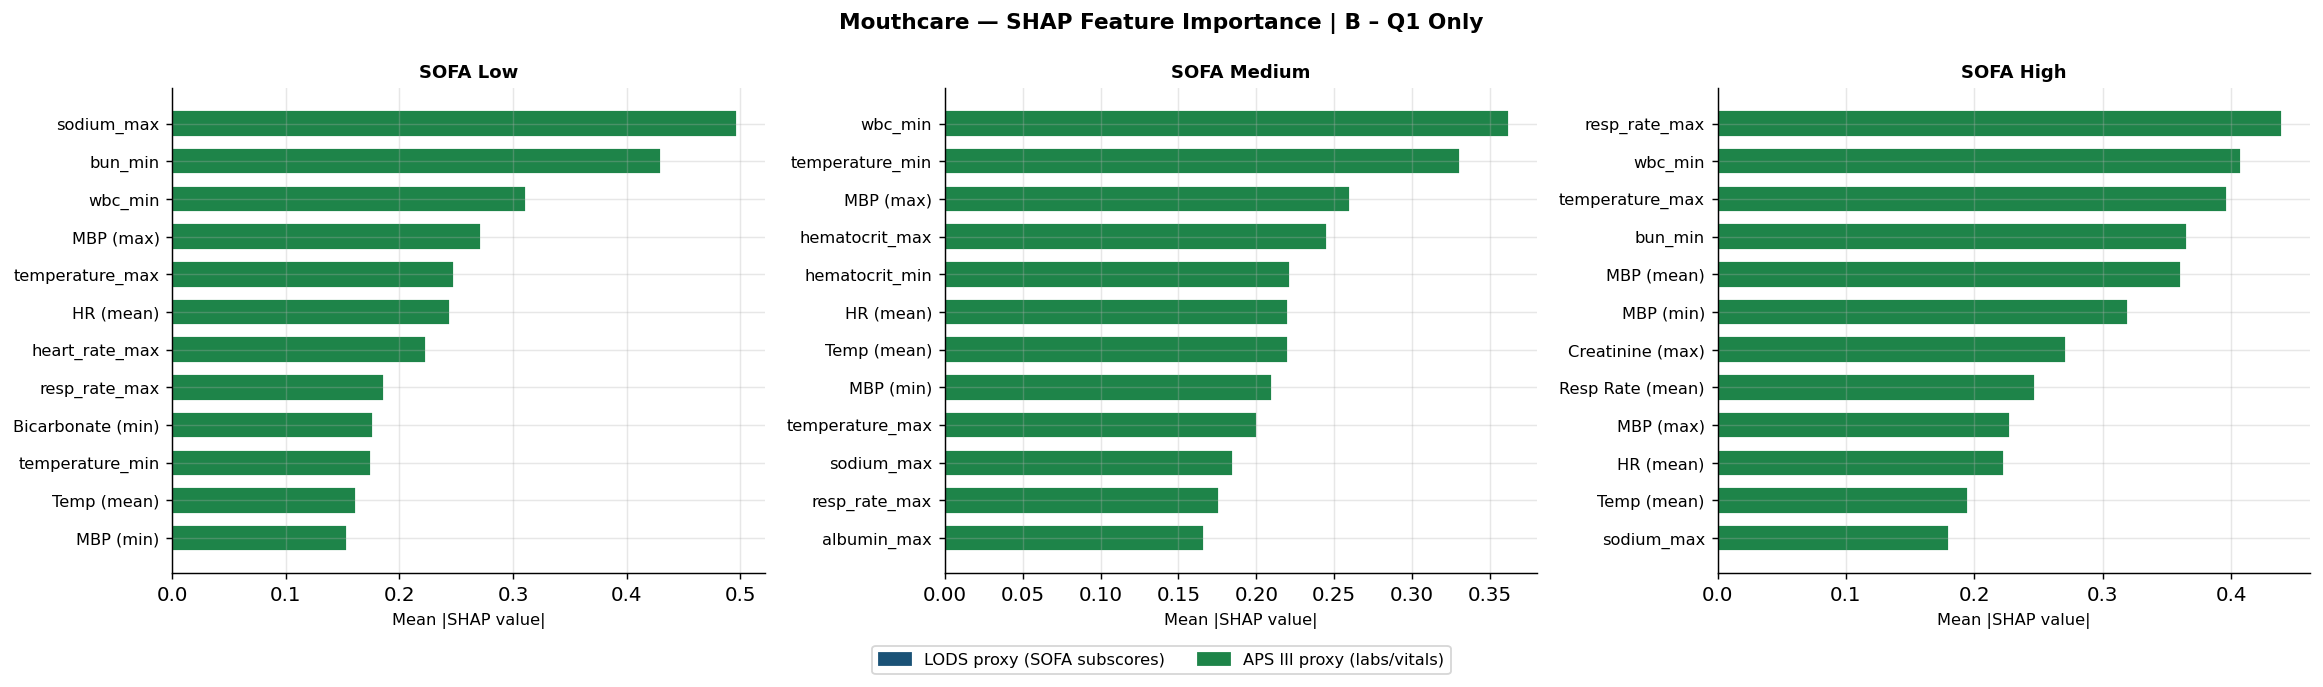

  Saved: figures/fig4_shap_mouthcare_modelB.png


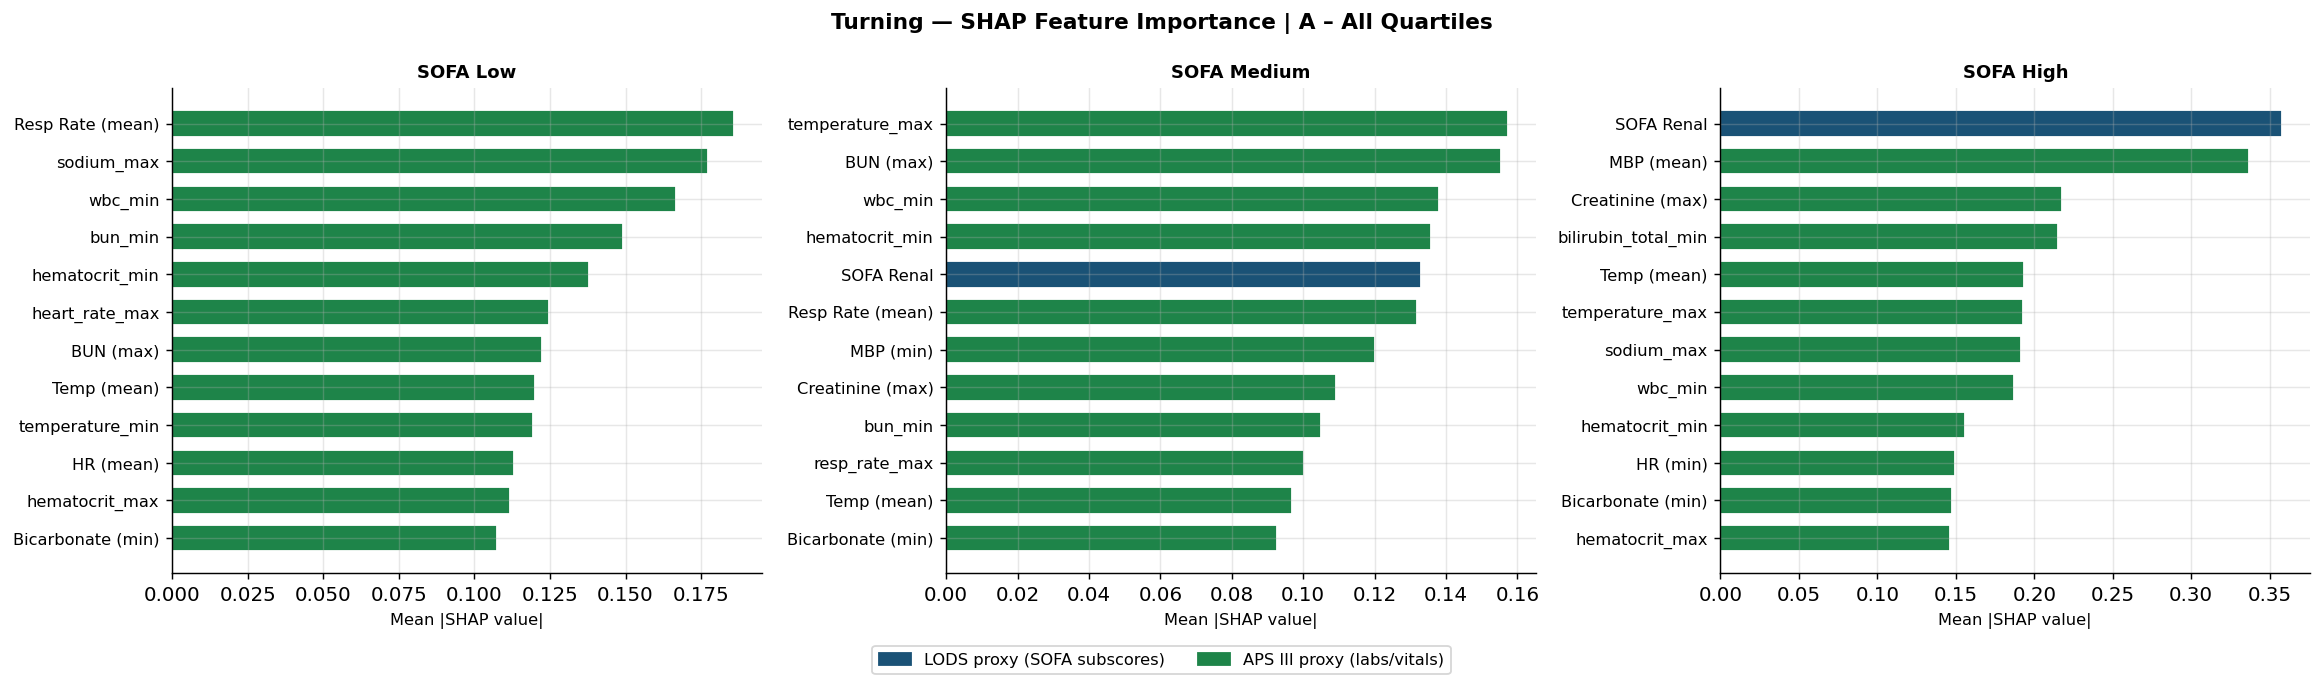

  Saved: figures/fig4_shap_turning_modelA.png


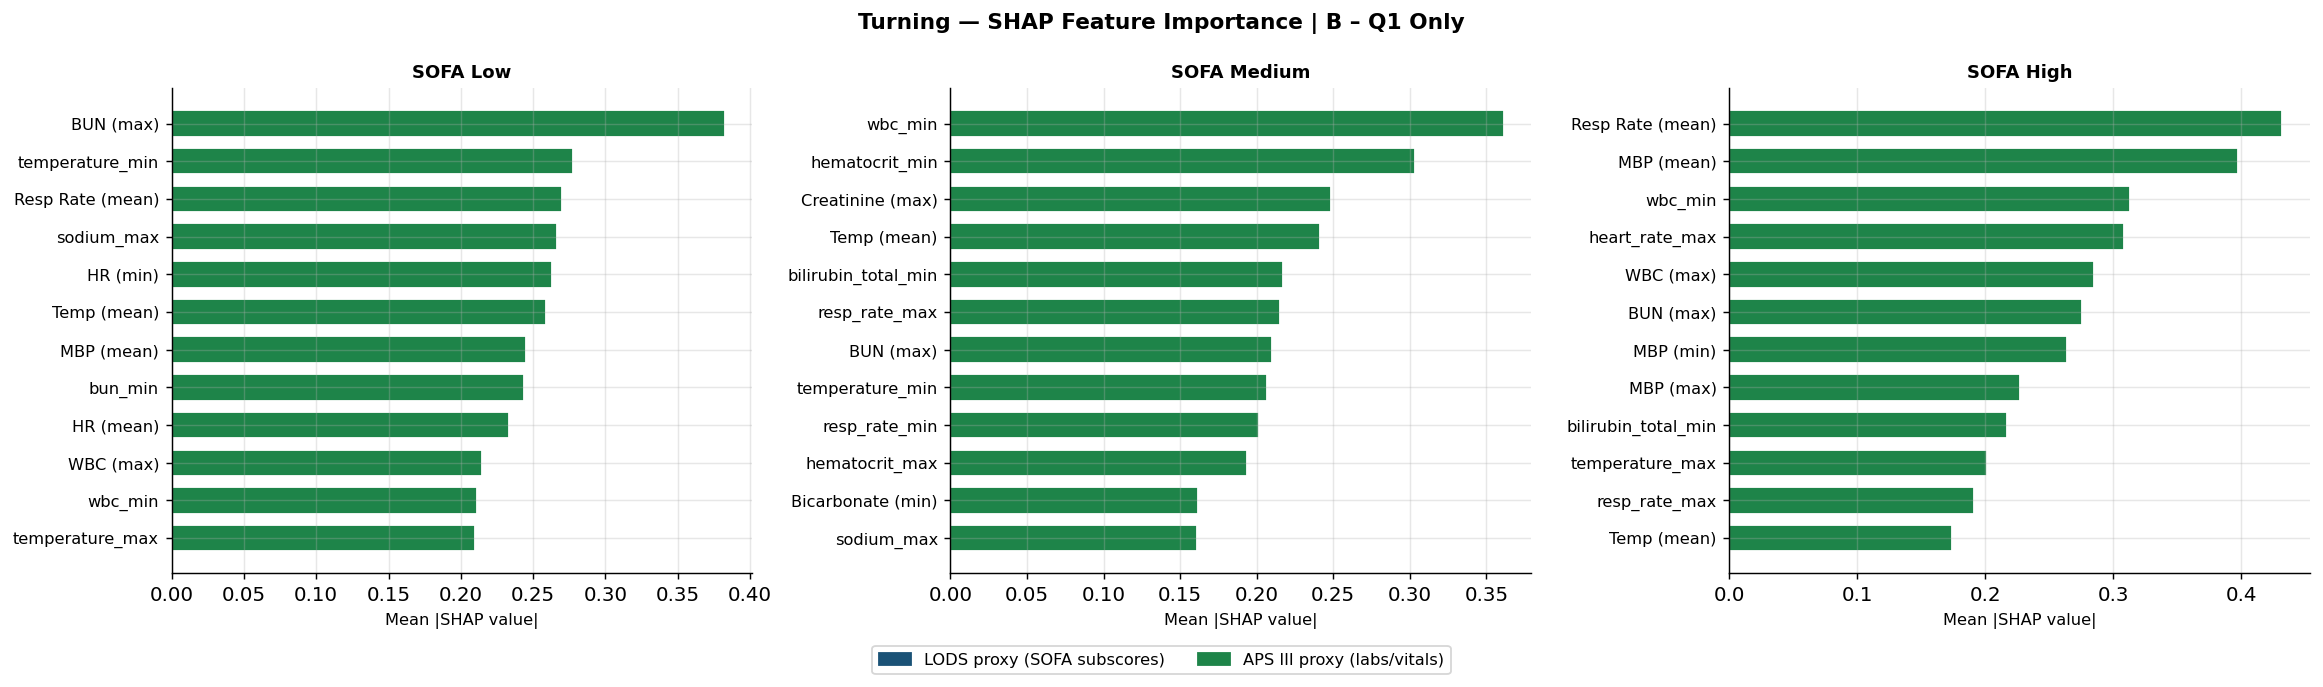

  Saved: figures/fig4_shap_turning_modelB.png


In [19]:
RENAME = {
    'gcs_min':'GCS (min)','respiration':'SOFA Respiration',
    'cardiovascular':'SOFA Cardiovascular','cns':'SOFA CNS',
    'renal':'SOFA Renal','liver':'SOFA Liver','coagulation':'SOFA Coagulation',
    'mbp_min':'MBP (min)','mbp_mean':'MBP (mean)','mbp_max':'MBP (max)',
    'heart_rate_min':'HR (min)','heart_rate_mean':'HR (mean)',
    'resp_rate_mean':'Resp Rate (mean)','temperature_mean':'Temp (mean)',
    'creatinine_max':'Creatinine (max)','bun_max':'BUN (max)',
    'albumin_min':'Albumin (min)','bicarbonate_min':'Bicarbonate (min)',
    'bilirubin_total_max':'Bilirubin (max)','wbc_max':'WBC (max)',
}
SOFA_SET = {'SOFA Respiration','SOFA Cardiovascular','SOFA CNS',
            'SOFA Renal','SOFA Liver','SOFA Coagulation'}

def plot_shap_grid(care_label, model_name, save_path, top_n=12):
    sevs = [s for s in SEVERITY_LABELS
            if (care_label, s, model_name) in shap_store]
    if not sevs:
        print(f'  No SHAP data for {care_label} | {model_name}')
        return
    fig, axes = plt.subplots(1, len(sevs), figsize=(6*len(sevs), 5))
    if len(sevs) == 1:
        axes = [axes]
    for ax, sev in zip(axes, sevs):
        model, X_train, feats = shap_store[(care_label, sev, model_name)]
        sample = X_train.sample(min(400, len(X_train)), random_state=RANDOM_STATE)
        explainer   = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(sample)
        mean_abs    = pd.Series(np.abs(shap_values).mean(axis=0), index=feats)
        top         = mean_abs.nlargest(top_n).sort_values()
        top.index   = [RENAME.get(f,f) for f in top.index]
        colors      = ['#1A5276' if f in SOFA_SET else '#1E8449' for f in top.index]
        ax.barh(range(len(top)), top.values, color=colors, edgecolor='white', height=0.7)
        ax.set_yticks(range(len(top)))
        ax.set_yticklabels(top.index, fontsize=9)
        ax.set_xlabel('Mean |SHAP value|', fontsize=9)
        ax.set_title(f'SOFA {sev}', fontweight='bold', fontsize=10)
    patch1 = mpatches.Patch(color='#1A5276', label='LODS proxy (SOFA subscores)')
    patch2 = mpatches.Patch(color='#1E8449', label='APS III proxy (labs/vitals)')
    fig.legend(handles=[patch1,patch2], fontsize=9,
               loc='lower center', bbox_to_anchor=(0.5,-0.05), ncol=2)
    fig.suptitle(f'{care_label} — SHAP Feature Importance | {model_name}',
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()
    print(f'  Saved: {save_path}')

for care in ['Mouthcare','Turning']:
    for mname, mshort in [('A – All Quartiles','A'),('B – Q1 Only','B')]:
        plot_shap_grid(care, mname,
                       os.path.join(OUTPUT_FOLDER, f'fig4_shap_{care.lower()}_model{mshort}.png'))

## 13. Results Export

In [ ]:
HDR_BG='1F3864'; HDR_FG='FFFFFF'; DARK_BG='2E4057'; BORDER='BDC3C7'
SEV_BG  = {'Low':'EBF5FB','Medium':'FEF9E7','High':'FDEDEC'}
MOD_BG  = {'A – All Quartiles':'D6E4F0','B – Q1 Only':'D5F5E3'}
thin    = Border(left=Side('thin',color=BORDER),right=Side('thin',color=BORDER),
                 top=Side('thin',color=BORDER), bottom=Side('thin',color=BORDER))

DISP_COLS = ['Care Type','Severity','Model','Test Set','N','Mortality%',
             'AUROC_CI','Sensitivity','Specificity','PPV','NPV','F1']
DISP_COLS = [c for c in DISP_COLS if c in results_df.columns]
COL_W     = {'Care Type':13,'Severity':10,'Model':22,'Test Set':20,'N':7,
             'Mortality%':12,'AUROC_CI':28,'Sensitivity':28,'Specificity':28,
             'PPV':28,'NPV':28,'F1':28}

def write_sheet(ws, df, title):
    cols = list(df.columns); nc = len(cols)
    ws.merge_cells(start_row=1,start_column=1,end_row=1,end_column=nc)
    c=ws.cell(1,1,title)
    c.font=Font('Calibri',bold=True,size=13,color=HDR_FG)
    c.fill=PatternFill('solid',fgColor=DARK_BG)
    c.alignment=Alignment(horizontal='center',vertical='center')
    ws.row_dimensions[1].height=24
    for ci,cn in enumerate(cols,1):
        c=ws.cell(2,ci,cn)
        c.font=Font('Calibri',bold=True,size=10,color=HDR_FG)
        c.fill=PatternFill('solid',fgColor=HDR_BG)
        c.alignment=Alignment(horizontal='center',vertical='center',wrap_text=True)
        c.border=thin
    ws.row_dimensions[2].height=34
    for ri,(_,row) in enumerate(df.iterrows(),3):
        sev=str(row.get('Severity',''))
        mod=str(row.get('Model',''))
        bg=MOD_BG.get(mod, SEV_BG.get(sev,'F8F9FA'))
        for ci,cn in enumerate(cols,1):
            val=row[cn]; c=ws.cell(ri,ci,val)
            c.font=Font('Calibri',size=10,bold=(cn=='AUROC_CI'))
            c.fill=PatternFill('solid',fgColor=bg)
            c.border=thin
            c.alignment=Alignment(
                horizontal='left' if cn in ('Care Type','Severity','Model','Test Set') else 'center',
                vertical='center')
        ws.row_dimensions[ri].height=18
    for ci,cn in enumerate(cols,1):
        ws.column_dimensions[get_column_letter(ci)].width=COL_W.get(cn,14)
    ws.freeze_panes='A3'

display_df = results_df[DISP_COLS]
wb = Workbook()
wb.remove(wb.active)

sheets = [
    ('All Results',     display_df,  'All Results — Mouthcare & Turning'),
    ('Mortality Table', mort_tbl,    'Mortality by Severity × Quartile (within-severity Q assignment)'),
]
for care in ['Mouthcare','Turning']:
    for sev in SEVERITY_LABELS:
        sub = display_df[
            (display_df['Care Type']==care) & (display_df['Severity']==sev)
        ]
        if len(sub)==0: continue
        sofa_range = {'Low':'0–6','Medium':'7–11','High':'≥12'}[sev]
        sheets.append((
            f'{care[:4]} – {sev}',
            sub,
            f'{care} | {sev} Severity (SOFA {sofa_range})'
        ))

for sname, df_s, title in sheets:
    ws = wb.create_sheet(title=sname)
    write_sheet(ws, df_s.reset_index(drop=True), title)
    print(f'   Sheet "{sname}" ({len(df_s)} rows)')

wb.save(OUTPUT_EXCEL)
print(f'\n Excel saved : {os.path.abspath(OUTPUT_EXCEL)}')
print(f' Figures in  : {os.path.abspath(OUTPUT_FOLDER)}/')

## 14. Interpretation Framework

### Primary evidence criteria

| Evidence | Source | Criterion supporting hypothesis |
|---|---|---|
| Mortality gradient | Section 8 — Mortality Table | Mortality rate increases Q1 to Q4 within each severity stratum |
| Severity balance | Section 5 output | Mean SOFA score is comparable across Q1–Q4 within each stratum |
| Model B discrimination | Section 9–10 — AUROC plots | AUROC decreases from Q1 to Q4 for Model B within each severity stratum |
| Calibration breakdown | Section 11 — Calibration curves | Q3/Q4 points fall above the diagonal for Model B |
| Feature validity | Section 12 — SHAP | SOFA subscores and clinical severity features dominate model predictions |

---

### Definitions

- **Q1**: Highest care frequency (smallest mean interval between care events)
- **Q4**: Lowest care frequency (largest mean interval between care events)
- **Severity strata**: Low = SOFA 0–6 | Medium = SOFA 7–11 | High = SOFA ≥12

---

### Justification of SOFA cut-points

The severity cut-points used in this analysis align with the Sepsis-3 consensus definition (Singer et al., *JAMA*, 2016), in which a SOFA score ≥2 defines acute organ dysfunction. The thresholds of 0–6 (low), 7–11 (medium), and ≥12 (high) reflect clinically meaningful strata corresponding to absent or minimal dysfunction, moderate multi-organ failure, and severe dysfunction with substantially elevated predicted mortality, respectively. The use of pre-specified, clinically grounded cut-points avoids data-driven threshold selection and supports comparability with published critical care literature.